# Skin Lesion Classification 

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Description](#Data-description)
3. [Exploratory Data Analysis](#Exploratory-data-analysis)
    - [3.1 Import important libraries](#Import-important-libraries)
    - [3.2 Loading and Inspecting the Labels Data](#Loading-and-inspecting-the-labels-data)
    - [3.3 Visualize Image Samples](#Visualize-image-samples)
    - [3.4 Data Cleaning](#Data-cleaning)
    - [3.5 Data Preparation](#Data-preparation)
    - [3.6 Splitting the Dataset](#Splitting-the-dataset)
    - [3.7 Plotting Training and Validation Dataset Samples](#Plotting-training-and-validation-dataset-samples)
4. [Model Architecture](#Model-architecture)
    - [4.1 Data Augmentation](#Data-augmentation)
    - [4.2 Create DataLoaders](#Create-dataloaders)
    - [4.3 Model Architecture](#Model-architecture)
    - [4.4 Loss Function and Optimizer](#Loss-function-and-optimizer)
    - [4.5 Training Loop](#Training-loop)
    - [4.6 Transfer Learning and Evaluation](#Transfer-learning-and-evaluation)
    - [4.7 Model Inferencing](#Model-inferencing)
5. [Results and Analysis](#Results-and-Analysis)
    - [5.1 Hyperparameter Tuning and Model Comparison](#hyperparameter-tuning-and-model-comparison)
    - [5.2 Analysis of Results](#analysis-of-results)
    - [5.3 Challenges](#challenges)
    - [5.4 Recommendations](#recommendations)
6. [Conclusion](#Conclusion)
    - [6.1 Learning and Takeaways](#learnings-and-takeaways)
    - [6.2 Future Work](#future-work)

# Introduction

Globally, an estimated 3 billion people have inadequate access to medical care for skin disease. 

In this project, I aim to tackle the problem of skin lesion classification, a critical task in the field of dermatology. Skin lesions, which are abnormal growths or patches on the skin, can often be indicative of various skin diseases, including skin cancer. 

## Overview of the problem 

The task is to classify skin lesions into two categories: malignant and benign. Malignant lesions are harmful and can be cancerous, while benign lesions are not. This is a binary classification problem, and it's challenging due to the subtle differences between malignant and benign lesions that can even be difficult for trained dermatologists to distinguish.

## Importance in medical imaging 

Medical imaging is a crucial tool in modern healthcare, allowing for non-invasive diagnosis and monitoring of diseases. In dermatology, imaging can be used to identify and classify skin lesions, potentially catching harmful conditions like skin cancer early and improving patient outcomes. However, manual classification of skin lesions can be time-consuming and subjective, leading to variability in diagnosis. An automated, accurate classification system can assist healthcare professionals and provide more consistent results.

## Motivation

The motivation for this project is to leverage the power of machine learning, specifically convolutional neural networks (CNNs), to automate the process of skin lesion classification. By training a model on a diverse, validated dataset of skin lesion images, I hope to develop an algorithm that can accurately classify skin lesions and potentially serve as a tool for early detection of skin cancer.


# Data description

The dataset used in this project, referred to as the DDI dataset, consists of 656 images representing 570 unique patients. These images were retrospectively selected from pathology reports in Stanford Clinics from 2010 to 2020.

Each image in the dataset has been expertly curated. The skin tone for each image was labeled based on in-person evaluation at the clinic visit, cross-referenced against demographic photos and review of the clinical images by two board-certified dermatologists. The diagnosis for each image was based on pathology reports from biopsy. These reports and the corresponding image were reviewed by a board-certified dermatologist and dermatopathologist.

The dataset was designed to allow direct comparison between Fitzpatrick I-II and Fitzpatrick V-VI skin tones by matching diagnostic category, age within 10 years, gender, and date of photograph within 3 years. This design also allows us to evaluate previously developed state-of-the-art diagnostic algorithms across skin tones.

- Files names with imageID
- metadata.csv provides information for images 
- Markings and ruler in the images does not influence the model's performance
- No duplicates
- More benign images than malignant 


# Exploratory data analysis

## Import important libraries

The following block of code sets up the necessary imports and configurations for a PyTorch-based machine learning project aimed at skin cancer detection. It imports essential libraries for data manipulation (NumPy, Pandas), data visualization (Matplotlib, Plotly), and deep learning (PyTorch, torchvision). Additionally, it includes utilities for image processing (PIL) and data handling (torch.utils.data). The code also ensures reproducibility by fixing the random seed with torch.manual_seed(42). This setup is fundamental for data loading, augmentation, model building, training, and evaluation tasks in the context of a deep learning project.

I have loaded the dataset in a separate py file due to some errors in model training when it was loaded in the same notebook. I call the `DDI_Dataset` in the chunk as well. 

I have chosen the area under the Receiver Operating Characteristic (ROC) curve (AUC) as the evaluation metric. The ROC curve plots the true positive rate against the false positive rate at various thresholds, and the AUC measures the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. An ideal model would achieve an AUC of 1, correctly classifying all positive samples without any false positives.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from PIL import Image
import os
import torch

import time

from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import random

import torch.nn as nn
import torchvision.models as models
import tqdm
from tqdm import tqdm

from dataset import DDI_Dataset
from sklearn.metrics import roc_auc_score

#Fix random seed
torch.manual_seed(42)

## Loading and inspecting the labels data

This block of code reads the ddi_metadata.csv file containing the ground truth labels for the  images into a Pandas DataFrame (metadata). It then prints the shape of the DataFrame to show the number of rows and columns. Additionally, it prints the distribution of the label values (i.e., how many positive and negative samples are present). Finally, it displays the first few rows of the DataFrame in a markdown format for a quick preview of the data.

In [2]:
metadata = pd.read_csv('../data/DDI/images/ddi_metadata.csv', index_col=0)

In [3]:
metadata.shape

(656, 5)

In [4]:
metadata['malignant'].value_counts()

False    485
True     171
Name: malignant, dtype: int64

In [5]:
metadata.head()

DDI_ID    DDI_file  skin_tone  malignant                          disease
0       1  000001.png         56       True                 melanoma-in-situ
1       2  000002.png         56       True                 melanoma-in-situ
2       3  000003.png         56       True                mycosis-fungoides
3       4  000004.png         56       True  squamous-cell-carcinoma-in-situ
4       5  000005.png         12       True             basal-cell-carcinoma

## Visualize image samples

This block calls the dataset, converts the images to tensors and applies some transformation to ensure randomization in the dataset. Then it plots a grid of images for visual inspection.

In [6]:
#Define transformations
#No Lambda function needed as the images are already in RGB format
means = [0.485, 0.456, 0.406]
stds  = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds),
    #Data augmentation
    T.RandomHorizontalFlip(),
    T.RandomRotation(10)
])

In [7]:
# Instantiate the DDI_Dataset class
ddi = DDI_Dataset(root='../data/DDI/images', transform=test_transform)


In [8]:
def plot_data_figure(dataset, ids, title, nrows=5, ncols=15):
    """
    Plots a grid of images for visual inspection.

    Args:
        dataset (object): The dataset object.
        ids (array): Array of image IDs.
        title (str): Title of the plot.
        nrows (int): Number of rows in the grid.
        ncols (int): Number of columns in the grid.
    """
    # Create a figure with specified number of rows and columns
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing between subplots

    # Loop through the image IDs and plot each image
    for i, index in enumerate(ids[:nrows * ncols]):
        # Get the image using the get_sample_image method
        image, target, skin_tone = dataset.get_sample_image(index)
        
        # Plot the image in the grid
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(image)
        plt.axis('off')  # Turn off axis

    # Set the title of the plot
    plt.suptitle(title, y=0.94)


malignant = metadata[metadata['malignant'] == True].index.values   # get the indices of malignant cases
normal    = metadata[metadata['malignant'] == False].index.values    # get the indices of the normal cases

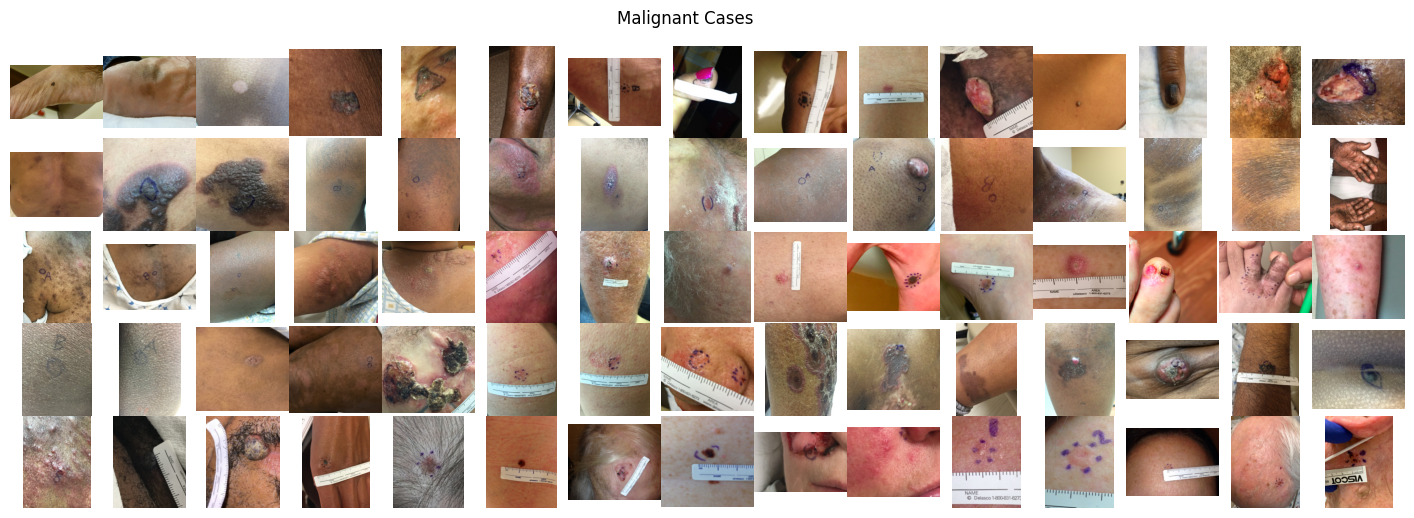

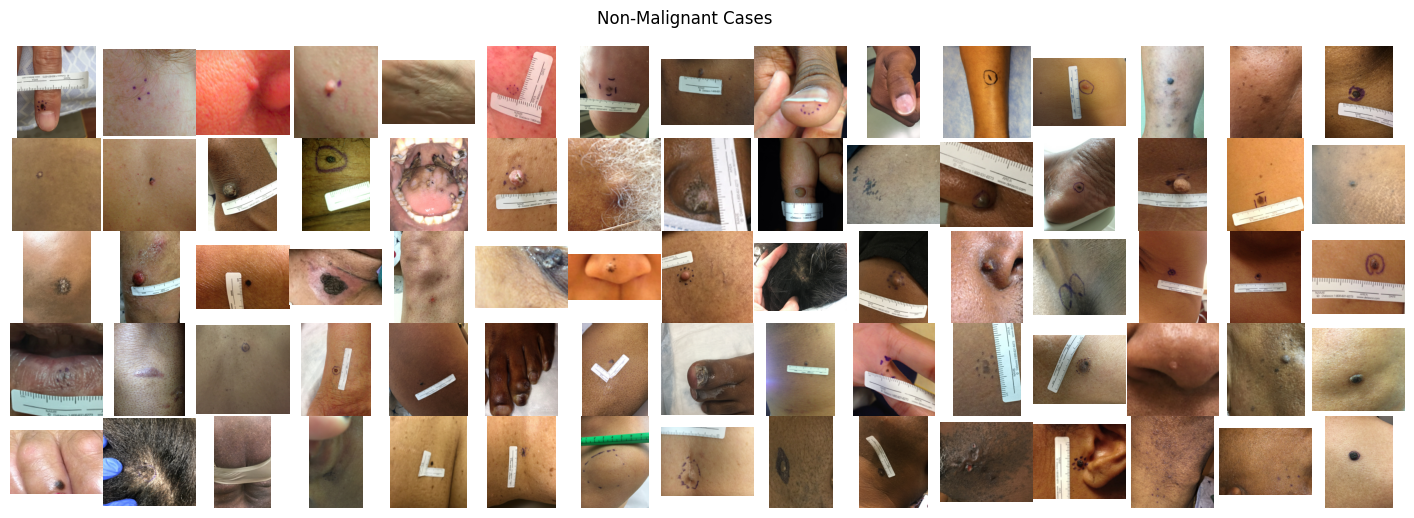

In [9]:
# Plot malignant cases
plot_data_figure(ddi, malignant, 'Malignant Cases')

# Plot non-malignant cases
plot_data_figure(ddi, normal, 'Non-Malignant Cases')

## Data cleaning

To ensure that the dataset does not contain any duplicate entries, I will check for duplicates here and drop them. Other cleaning techniques have been employed in the transformation part using pytorch's Transform functionality. 

In [10]:
#Check for duplicates

metadata.duplicated().sum()

0

In [11]:
#Check the sizes of the images

def check_image_sizes(dataset):
    sizes = []
    for i in range(len(dataset)):
        image, _, _ = dataset[i]
        sizes.append(image.size())
    return sizes


## Data preparation

This has been done in the `dataset.py` notebook to prepare the DDI_Dataset class which is a custom Dataset class designed for use with PyTorch models, specifically for this skin lesion classification task with diverse skin tone images. It facilitates the loading, transformation, and handling of images and their corresponding labels from a specified directory.

The DDI_Dataset class streamlines the process of preparing data for training and evaluating deep learning models in the context of skin cancer detection.

In [11]:
#DDI Dataset 
ddi

In [12]:
print(dir(ddi))

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'annotations', 'get_sample_image', 'root', 'transform']


In [13]:
# load an example tensor
img,label, skin_tone = ddi[0]
print(img.shape, torch.min(img), torch.max(img), label, skin_tone)

torch.Size([3, 224, 224]) tensor(-1.8044) tensor(1.7283) 1 56


- torch.Size([3, 224, 224]): This is the shape of the tensor representing the image. The image has 3 channels (likely Red, Green, and Blue channels), and each channel is a 224x224 pixel grid. 

- tensor(-1.8044): This is the minimum value in my image tensor. Since I've normalized your images using T.Normalize(mean=means, std=stds), the pixel values in the image tensor can be negative. The mean and standard deviation values used for normalization determine the range of the pixel values.

- tensor(1.7283): This is the maximum value in the image tensor. Again, this value is influenced by the normalization of my images.



## Splitting the dataset

In order to monitor the model's performance throughout the training process, it's crucial to have a separate validation dataset for evaluation. This allows us to adjust the model's parameters without bias. Furthermore, to ensure an unbiased assessment of the final model, we'll use a separate test dataset. This approach helps us avoid data leakage and gives us a more accurate measure of the model's ability to generalize to unseen data.

In [14]:
#Splitting the dataset into training, validation, and test sets
def split_dataset(dataset, val_split=0.2, test_split=0.1, shuffle=True, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    
    val_split = int(np.floor(val_split * dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    train_split = dataset_size - val_split - test_split

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices = indices[:train_split]
    val_indices = indices[train_split:train_split+val_split]
    test_indices = indices[train_split+val_split:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

In [15]:
train_df, val_df, test_df = split_dataset(ddi, val_split=0.2)

## Plotting training and validation dataset samples


In [16]:
#Plot the train and val dfs

def plot_df_samples(train_df, val_df, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

    for i in range(num_samples):
        #Plot training samples
        img, label, skin_tone = train_df[i]
        if hasattr(img, 'numpy'):
            img = img.numpy()
        #If the image is in CHW format
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        axes[0, i].imshow(img) # dont want to permute the image
        axes[0, i].set_title(f"Training: {label}, {skin_tone}")
        axes[0, i].axis('off')

        #Plot validation samples
        img, label, skin_tone = val_df[i]
        if hasattr(img, 'numpy'):
            img = img.numpy()
        #If the image is in CHW format
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Validation: {label}, {skin_tone}")
        axes[1, i].axis('off')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.405462..2.0474076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5105042..2.0299783

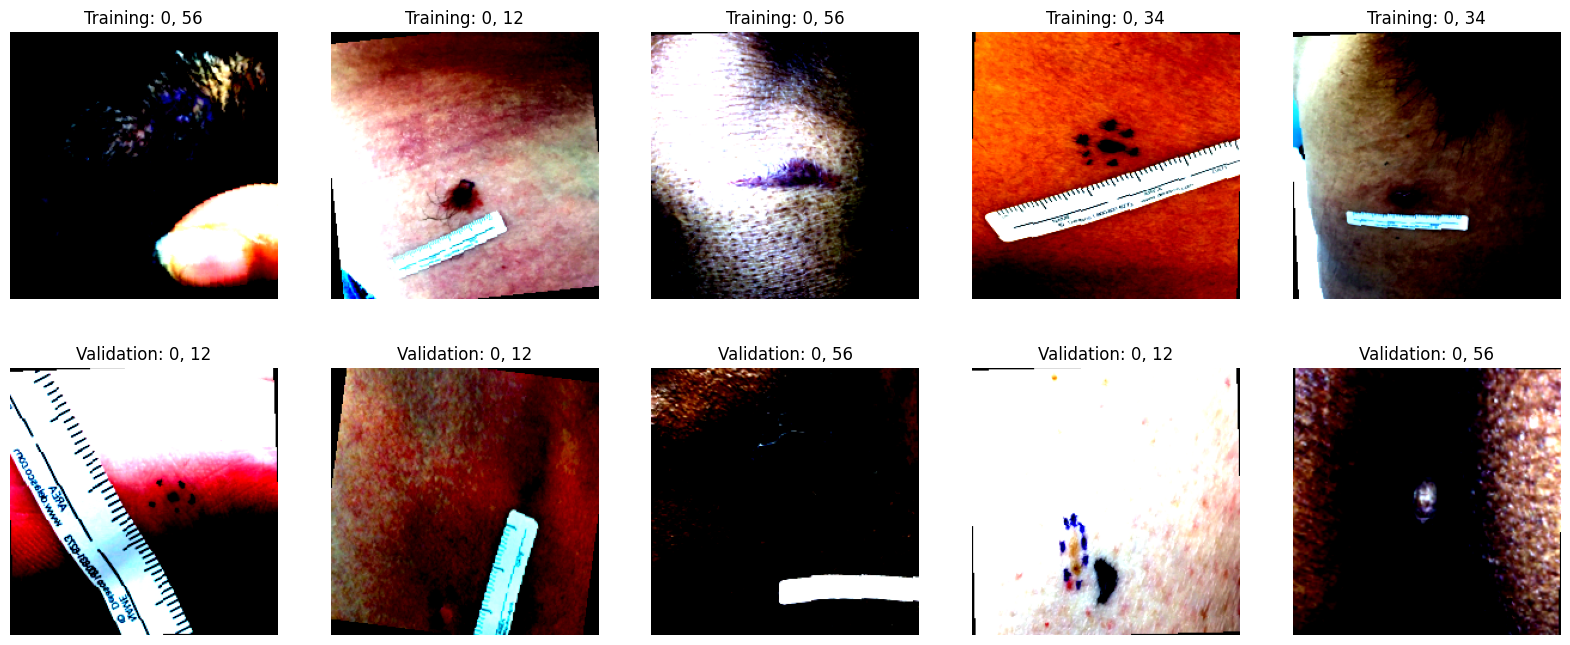

In [17]:
plot_df_samples(train_df, val_df)

# Model Architecture

## Data augmentation

This code defines image transformations for the training, validation, and test datasets in a PyTorch-based project. For the training dataset, the transformations include data augmentation techniques such as random resizing and cropping, horizontal flipping, rotation, and color jittering. These techniques can help improve the model's ability to generalize from the training data.

For the validation and test datasets, the transformations are simpler: the images are resized and center cropped to ensure consistency in input size. No data augmentation is applied to these datasets as they serve as a 'ground truth' for model evaluation.

All datasets undergo a conversion to PyTorch tensors and normalization of their pixel values. The normalization uses predefined mean and standard deviation values to standardize the pixel intensity across all images.

As I have applied these during initiliazation of the dataset class, I have commented out the code itself to prevent any unnecessary distortion. 


In [ ]:

# crop_size = 200

# train_transform = T.Compose([
#     T.RandomResizedCrop(crop_size),
#     T.RandomHorizontalFlip(),
#     T.RandomRotation(10),
#     T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# val_test_transform = T.Compose([
#     T.Resize(256),
#     T.CenterCrop(224),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

## Create dataloaders

This code creates data loaders for the training, validation and test datasets using PyTorch's DataLoader class. The training data loader (train_dl) is configured with a batch size of 32 and shuffling enabled to ensure randomization at each epoch. The validation data loader (val_dl) also uses a batch size of 32 but does not shuffle the data to maintain order during evaluation. 


In [18]:
#Create dataloaders function 

train_loader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)
# - batch_size=32: Number of samples per batch to load.
# - shuffle=True: Shuffle the data at every epoch to ensure randomization.
# - num_workers=4: Number of worker processes to use for data loading.
val_loader = DataLoader(val_df, batch_size=32, shuffle=False, num_workers=4)
# - batch_size=32: Number of samples per batch to load.
# - shuffle=False: Do not shuffle the data as we want to maintain the order.
# - num_workers=4: Number of worker processes to use for data loading.

test_loader = DataLoader(test_df, batch_size=32, shuffle=False, num_workers=4)
# - batch_size=32: Number of samples per batch to load.
# - shuffle=False: Do not shuffle the data as we want to maintain the order.
# - num_workers=4: Number of worker processes to use for data loading.

In [19]:
#Check a sample batch from the train_loader
for images, labels, skin_tones in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Label batch dimensions:', labels.shape)
    print('Skin tone batch dimensions:', skin_tones.shape)
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])
Skin tone batch dimensions: torch.Size([32])


## Model architecture

For this project, I will be using a couple fo pretrained models and customizing them for this skin lesion classification task to achieve the best accuracy and most sensible confusion matrix. 

### Model 1 : ResNet50 

**Structure:** ResNet50 is a variant of ResNet model which has 50 layers deep. The model leverages the concept of residual learning to ease the training of such deep networks. The main innovation of ResNet is the introduction of "skip connections" which allow the gradient to be directly backpropagated to earlier layers.

**Benefits of Design:** The residual learning framework makes it easier to optimize the model and it can gain accuracy from considerably increased depth. This makes ResNet50 a good choice for tasks that benefit from deeper networks.

**Parameters:** The ResNet50 model in this code is pre-trained, meaning it has been trained on a large benchmark dataset (ImageNet) and can therefore be used to extract meaningful features from our images. The final fully connected layer is replaced with a custom layer that has a dropout rate of 0.1 and is designed to output two classes.

**How it Works:** The ResNet50 model takes an image as input and passes it through its layers to output a feature map. This feature map is then flattened and passed through the custom fully connected layer to output the final class probabilities.

### Model 2: DenseNet121

**Structure:** DenseNet121 is a variant of DenseNet which has 121 layers. DenseNet improves the vanishing-gradient problem, strengthens feature propagation, encourages feature reuse, and substantially reduces the number of parameters.

**Benefits of Design:** DenseNet connects each layer to every other layer in a feed-forward fashion. Whereas traditional convolutional networks with L layers have L connections—one between each layer and its subsequent layer—DenseNet has L(L+1)/2 direct connections. This helps in improving the flow of information and gradients throughout the network, which in turn makes it easier to train.

**Parameters:** The DenseNet121 model in this code is also pre-trained. The classifier is replaced with a custom one that consists of three linear layers, each followed by a ReLU activation and batch normalization. Dropout is also applied before the first linear layer.

**How it Works:** The DenseNet121 model takes an image as input and passes it through its layers to output a feature map. This feature map is then passed through the custom classifier to output the final class probabilities.


In [51]:
#Model 1 - Pretrained,resnet50
from torchvision import models 
class SkinLesionModel_resnet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.1):
        super(SkinLesionModel_resnet, self).__init__()
        self.model = models.resnet50(pretrained=True)

        for param in self.model.layer4.parameters():
            param.requires_grad = True
                
        # Replace the final fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, num_classes)
        )
    
        print(f'Resnet created with {num_classes} classes and dropout rate of {dropout_rate}')
        
    def forward(self, x):
        return self.model(x)


In [52]:
#Model 2 - Pretrained, DenseNet121
class CustomDenseNet121(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.1):
        super(CustomDenseNet121, self).__init__()
        
        # Load pre-trained DenseNet121
        self.model = models.densenet121(pretrained=True)
        
        # Replace the classifier with a custom one
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(self.model.classifier.in_features, 256, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, num_classes, bias=False),
            nn.BatchNorm1d(num_classes)
        )
        
        print(f'DenseNet121 created with {num_classes} classes and dropout rate of {dropout_rate}')
        
        model_parameters = filter(lambda p: p.requires_grad, self.model.parameters())
        params = sum([p.numel() for p in model_parameters])
        print(f'Model has {params} trainable params.')

    def forward(self, x):
        return self.model(x)


In [22]:
model_1 = SkinLesionModel_resnet()

/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet created with 2 classes and dropout rate of 0.1


In [23]:
model_2 = CustomDenseNet121()

DenseNet121 created with 2 classes and dropout rate of 0.1
Model has 7249796 trainable params.


/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Loss function and optimizer

For training the models for image classification, this is recommended: 

### Loss function: 

-  Cross-Entropy Loss: This loss function is commonly used for multi-class classification problems. It combines log_softmax and nll_loss in one single class.

### Optimizer 

-  Adam Optimizer: Adam (Adaptive Moment Estimation) is an efficient and widely used optimization algorithm that computes adaptive learning rates for each parameter. It generally performs well in practice for various deep learning tasks.

### Learning-rate Scheduler

-  ReduceLROnPlateau: This learning rate scheduler reduces the learning rate when a metric has stopped improving. It is useful for training models where the performance plateaus at certain learning rates. This scheduler reduces the learning rate by a factor of 10 (factor=0.1) if the monitored metric (e.g., validation loss) does not improve for patience number of epochs, helping the model to converge better by fine-tuning the learning rate during training. The verbose=True option provides updates when the learning rate is reduced.

By using these components, I can efficiently train my model with a suitable loss function, optimization algorithm, and learning rate schedule.

In [24]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, mode='min', factor=0.1, patience=10, verbose=True)
#for fine-tuning the model
optimizer_2 = optim.Adam(filter(lambda p: p.requires_grad, model_1.parameters()), lr=0.001)

/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [25]:
optimizer_3 = optim.Adam(model_2.parameters(), lr=0.001)
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, mode='min', factor=0.1, patience=10, verbose=True)

## Training loop 

The training loop is a critical part of the machine learning model training process. It iterates over the dataset multiple times (epochs) to progressively improve the model's performance by updating its weights based on the loss calculated from predictions. Here's a detailed explanation of how the training loop in the provided code works:

The training loop:

- Repeatedly processes the entire training dataset in batches.
- Updates the model parameters to minimize the loss.
- Evaluates the model on the validation dataset to monitor performance and prevent overfitting.
- Uses a learning rate scheduler to adjust the learning rate based on validation performance.
- Stores and visualizes the loss and accuracy to provide insights into the training process.

In [26]:
# Train and evaluate the model
def train_and_eval_s(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    best_val_acc = 0.0
    highest_acc = 0.0  # Track the highest accuracy
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    train_aucs, val_aucs = [], []
    lrs = []

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        loop = tqdm(train_loader, total=len(train_loader), leave=True)
        for images, labels, _ in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track learning rate
            lrs.append(optimizer.param_groups[0]['lr'])

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())  # Use predicted values here

            loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        epoch_auc = roc_auc_score(all_labels, all_preds)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        train_aucs.append(epoch_auc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_all_labels = []
        val_all_preds = []

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

                val_all_labels.extend(labels.cpu().numpy())
                val_all_preds.extend(outputs.argmax(1).cpu().numpy())  # Use argmax to get predicted class

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_epoch_auc = roc_auc_score(val_all_labels, val_all_preds)
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        val_aucs.append(val_epoch_auc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Train AUC: {epoch_auc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}, Val AUC: {val_epoch_auc:.4f}")

        if scheduler:
            scheduler.step(val_epoch_loss)

        # Checkpointing and Early Stopping
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            # Incorporate the time in the model name
            timestamp = time.strftime("%Y%m%d-%H%M%S")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_acc': val_epoch_acc,
                'train_accs': train_accs,
                'train_losses': train_losses,
                'val_accs': val_accs,
                'val_losses': val_losses,
                # Assuming you have variables train_aucs and val_aucs
                'train_aucs': train_aucs,
                'val_aucs': val_aucs,
                'lrs': lrs,
            }, f'best_model_{timestamp}.pth')
            print(f"Model with best validation accuracy saved at epoch {epoch} with {best_val_acc:.4f} accuracy!")

        # Early stopping
        if early_stopping and optimizer.param_groups[0]['lr'] < lr_min:
            print(f"EARLY STOPPING! Learning rate below {lr_min}")
            break

    return train_losses, train_accs, val_losses, val_accs, train_aucs, val_aucs

In [27]:

def plot_metrics(metric_train, metric_val, metric_name):
    plt.figure(figsize=(10, 7))
    plt.plot(metric_train, label='Train')
    plt.plot(metric_val, label='Validation')
    plt.title(f'Train vs Validation {metric_name} over epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

def plot_training_results(train_losses, train_accs, train_aucs, val_losses, val_accs, val_aucs):
    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_accs, val_accs, 'Accuracy')
    plot_metrics(train_aucs, val_aucs, 'AUC')

### Step-by-step explanation 

The function takes several arguments: the model to train, the training and validation data loaders, the loss function (criterion), the optimizer, an optional learning rate scheduler, the starting epoch number, and the total number of epochs to train for.

1. The function first determines the device to use for training (either a GPU if one is available, otherwise a CPU) and moves the model to that device.

2. It initializes variables to keep track of the best validation accuracy seen so far and lists to store the training and validation losses, accuracies, and AUC scores for each epoch.

3. The function then enters a loop over the specified number of epochs. For each epoch:

    - It sets the model to training mode.

    - It initializes variables to keep track of the running loss, the number of correct predictions, and the total number of predictions for this epoch. It also creates lists to store all the labels and predictions for this epoch.

    - It then enters a loop over the batches in the training data loader. For each batch:

        - It moves the images and labels to the device used for training.

        - It clears the gradients of the model parameters.

        - It passes the images through the model to get the output predictions.

        - It calculates the loss between the output predictions and the true labels.

        - It performs backpropagation to compute the gradients of the model parameters with respect to the loss.

        - It updates the model parameters using the optimizer.

        - It updates the running loss, the number of correct predictions, and the total number of predictions.

    - After going through all the batches, it calculates the average loss, accuracy, and AUC score for this epoch and appends them to the lists of training losses, accuracies, and AUC scores.

4. After training for each epoch, the function calls the evaluation function with the model and the validation data loader as arguments. The evaluation function:

    - Sets the model to evaluation mode.

    - Initializes variables to keep track of the running loss, the number of correct predictions, and the total number of predictions. It also creates lists to store all the labels and predictions.

    - Enters a loop over the batches in the validation data loader. For each batch:

        - It moves the images and labels to the device used for training.

        - It passes the images through the model to get the output predictions.

        - It calculates the loss between the output predictions and the true labels.

        - It updates the running loss, the number of correct predictions, and the total number of predictions.

    - After going through all the batches, it calculates the average loss, accuracy, and AUC score and returns these values.

5. The main function then appends the returned validation loss, accuracy, and AUC score to the lists of validation losses, accuracies, and AUC scores.

6. If a learning rate scheduler was provided, it updates the learning rate based on the validation loss.

7. If the validation accuracy for this epoch is better than the best validation accuracy seen so far, it updates the best validation accuracy and saves the current state of the model to a file.

8. After all epochs are completed, the function returns the lists of training and validation losses, accuracies, and AUC scores.

### Training Loop 

**Model A** : Resnet50 with 0.1 dropout rate 

In [46]:
#Train and evaluate the model
train_losses_a, train_accs_a, val_losses_a, val_accs_a, train_aucs_a, val_aucs_a  = train_and_eval_s(model_1, train_loader, val_loader, criterion, optimizer_1, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0)

Epoch 1/50: 100%|██████████| 15/15 [01:46<00:00,  7.09s/it, loss=0.437]


Epoch 1/50
Train Loss: 0.8411, Train Acc: 0.6652, Train AUC: 0.4885
Val Loss: 1.8463, Val Acc: 0.3435, Val AUC: 0.4134
Model with best validation accuracy saved at epoch 0 with 0.3435 accuracy!


Epoch 2/50: 100%|██████████| 15/15 [01:47<00:00,  7.14s/it, loss=0.62] 


Epoch 2/50
Train Loss: 0.6098, Train Acc: 0.7348, Train AUC: 0.5012
Val Loss: 14.3535, Val Acc: 0.4809, Val AUC: 0.4967
Model with best validation accuracy saved at epoch 1 with 0.4809 accuracy!


Epoch 3/50: 100%|██████████| 15/15 [01:49<00:00,  7.33s/it, loss=0.381]
/opt/miniconda3/envs/test1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/50
Train Loss: 0.5826, Train Acc: 0.7239, Train AUC: 0.4912
Val Loss: 0.5196, Val Acc: 0.7405, Val AUC: 0.5000
Model with best validation accuracy saved at epoch 2 with 0.7405 accuracy!


Epoch 4/50: 100%|██████████| 15/15 [01:44<00:00,  6.94s/it, loss=0.592]


Epoch 4/50
Train Loss: 0.5745, Train Acc: 0.7457, Train AUC: 0.5404
Val Loss: 0.5996, Val Acc: 0.7176, Val AUC: 0.5896


Epoch 5/50: 100%|██████████| 15/15 [01:46<00:00,  7.12s/it, loss=0.555]


Epoch 5/50
Train Loss: 0.5630, Train Acc: 0.7239, Train AUC: 0.5124
Val Loss: 0.9298, Val Acc: 0.7176, Val AUC: 0.5227


Epoch 6/50: 100%|██████████| 15/15 [01:44<00:00,  6.95s/it, loss=0.783]


Epoch 6/50
Train Loss: 0.5284, Train Acc: 0.7522, Train AUC: 0.5794
Val Loss: 0.7957, Val Acc: 0.7481, Val AUC: 0.6102
Model with best validation accuracy saved at epoch 5 with 0.7481 accuracy!


Epoch 7/50: 100%|██████████| 15/15 [01:40<00:00,  6.72s/it, loss=0.478]


Epoch 7/50
Train Loss: 0.5383, Train Acc: 0.7565, Train AUC: 0.6089
Val Loss: 0.6596, Val Acc: 0.6870, Val AUC: 0.5881


Epoch 8/50: 100%|██████████| 15/15 [01:42<00:00,  6.83s/it, loss=0.616]


Epoch 8/50
Train Loss: 0.5021, Train Acc: 0.7761, Train AUC: 0.6116
Val Loss: 2.0017, Val Acc: 0.7557, Val AUC: 0.5485
Model with best validation accuracy saved at epoch 7 with 0.7557 accuracy!


Epoch 9/50: 100%|██████████| 15/15 [01:40<00:00,  6.70s/it, loss=0.559]


Epoch 9/50
Train Loss: 0.5694, Train Acc: 0.7478, Train AUC: 0.5605
Val Loss: 0.5608, Val Acc: 0.7481, Val AUC: 0.5147


Epoch 10/50: 100%|██████████| 15/15 [01:42<00:00,  6.84s/it, loss=0.373]


Epoch 10/50
Train Loss: 0.5329, Train Acc: 0.7478, Train AUC: 0.5818
Val Loss: 0.5644, Val Acc: 0.7557, Val AUC: 0.5867


Epoch 11/50: 100%|██████████| 15/15 [01:45<00:00,  7.00s/it, loss=0.436]


Epoch 11/50
Train Loss: 0.5748, Train Acc: 0.7522, Train AUC: 0.5768
Val Loss: 0.8331, Val Acc: 0.7328, Val AUC: 0.5331


Epoch 12/50: 100%|██████████| 15/15 [01:43<00:00,  6.91s/it, loss=0.907]


Epoch 12/50
Train Loss: 0.5379, Train Acc: 0.7565, Train AUC: 0.5425
Val Loss: 1.1275, Val Acc: 0.7557, Val AUC: 0.5485


Epoch 13/50: 100%|██████████| 15/15 [01:43<00:00,  6.87s/it, loss=0.721]


Epoch 13/50
Train Loss: 0.5415, Train Acc: 0.7717, Train AUC: 0.6139
Val Loss: 0.5912, Val Acc: 0.7099, Val AUC: 0.5653


Epoch 14/50: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it, loss=0.563]


Epoch 14/50
Train Loss: 0.5188, Train Acc: 0.7478, Train AUC: 0.5685
Val Loss: 0.5940, Val Acc: 0.7481, Val AUC: 0.5147


Epoch 15/50: 100%|██████████| 15/15 [01:45<00:00,  7.00s/it, loss=0.64] 


Epoch 15/50
Train Loss: 0.4873, Train Acc: 0.7826, Train AUC: 0.6399
Val Loss: 0.5839, Val Acc: 0.7099, Val AUC: 0.5367


Epoch 16/50: 100%|██████████| 15/15 [01:45<00:00,  7.03s/it, loss=0.634]


Epoch 16/50
Train Loss: 0.4986, Train Acc: 0.7696, Train AUC: 0.6337
Val Loss: 0.8173, Val Acc: 0.7099, Val AUC: 0.6322


Epoch 17/50: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it, loss=0.558]


Epoch 17/50
Train Loss: 0.4864, Train Acc: 0.7696, Train AUC: 0.5965
Val Loss: 0.6389, Val Acc: 0.7405, Val AUC: 0.5669


Epoch 18/50: 100%|██████████| 15/15 [01:47<00:00,  7.18s/it, loss=0.387]


Epoch 18/50
Train Loss: 0.4868, Train Acc: 0.7804, Train AUC: 0.6703
Val Loss: 0.5752, Val Acc: 0.7634, Val AUC: 0.5919
Model with best validation accuracy saved at epoch 17 with 0.7634 accuracy!


Epoch 19/50: 100%|██████████| 15/15 [01:43<00:00,  6.91s/it, loss=0.409]


Epoch 19/50
Train Loss: 0.4637, Train Acc: 0.8000, Train AUC: 0.6597
Val Loss: 0.6332, Val Acc: 0.7481, Val AUC: 0.5816


Epoch 20/50: 100%|██████████| 15/15 [01:46<00:00,  7.08s/it, loss=0.537]


Epoch 20/50
Train Loss: 0.4598, Train Acc: 0.8065, Train AUC: 0.6721
Val Loss: 0.5306, Val Acc: 0.7863, Val AUC: 0.6455
Model with best validation accuracy saved at epoch 19 with 0.7863 accuracy!


Epoch 21/50: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it, loss=0.502]


Epoch 21/50
Train Loss: 0.4685, Train Acc: 0.7783, Train AUC: 0.6742
Val Loss: 0.5764, Val Acc: 0.7176, Val AUC: 0.5609


Epoch 22/50: 100%|██████████| 15/15 [01:46<00:00,  7.11s/it, loss=0.585]


Epoch 22/50
Train Loss: 0.4395, Train Acc: 0.7978, Train AUC: 0.6635
Val Loss: 0.6762, Val Acc: 0.6641, Val AUC: 0.5535


Epoch 23/50: 100%|██████████| 15/15 [01:46<00:00,  7.12s/it, loss=0.348]


Epoch 23/50
Train Loss: 0.4229, Train Acc: 0.8065, Train AUC: 0.6827
Val Loss: 0.6155, Val Acc: 0.7099, Val AUC: 0.5940


Epoch 24/50: 100%|██████████| 15/15 [01:47<00:00,  7.16s/it, loss=0.65] 


Epoch 24/50
Train Loss: 0.4280, Train Acc: 0.8239, Train AUC: 0.7131
Val Loss: 1.0153, Val Acc: 0.5954, Val AUC: 0.5740


Epoch 25/50: 100%|██████████| 15/15 [01:46<00:00,  7.09s/it, loss=0.28] 


Epoch 25/50
Train Loss: 0.4281, Train Acc: 0.8261, Train AUC: 0.7040
Val Loss: 0.6594, Val Acc: 0.7557, Val AUC: 0.6631


Epoch 26/50: 100%|██████████| 15/15 [01:47<00:00,  7.17s/it, loss=0.401]


Epoch 26/50
Train Loss: 0.4203, Train Acc: 0.8043, Train AUC: 0.6839
Val Loss: 0.7460, Val Acc: 0.6489, Val AUC: 0.6196


Epoch 27/50: 100%|██████████| 15/15 [01:47<00:00,  7.14s/it, loss=0.231]


Epoch 27/50
Train Loss: 0.4387, Train Acc: 0.8174, Train AUC: 0.7034
Val Loss: 0.6208, Val Acc: 0.7252, Val AUC: 0.6234


Epoch 28/50: 100%|██████████| 15/15 [01:47<00:00,  7.15s/it, loss=0.488]


Epoch 28/50
Train Loss: 0.3904, Train Acc: 0.8217, Train AUC: 0.7170
Val Loss: 1.0069, Val Acc: 0.6336, Val AUC: 0.6093


Epoch 29/50: 100%|██████████| 15/15 [01:46<00:00,  7.13s/it, loss=0.576]


Epoch 29/50
Train Loss: 0.4384, Train Acc: 0.7978, Train AUC: 0.6874
Val Loss: 0.7091, Val Acc: 0.7176, Val AUC: 0.5036


Epoch 30/50: 100%|██████████| 15/15 [01:47<00:00,  7.20s/it, loss=0.229]


Epoch 30/50
Train Loss: 0.3849, Train Acc: 0.8391, Train AUC: 0.7447
Val Loss: 0.8391, Val Acc: 0.7252, Val AUC: 0.6043


Epoch 31/50: 100%|██████████| 15/15 [01:47<00:00,  7.16s/it, loss=0.274]


Epoch 31/50
Train Loss: 0.3872, Train Acc: 0.8304, Train AUC: 0.7441
Val Loss: 0.7673, Val Acc: 0.7557, Val AUC: 0.5867


Epoch 32/50: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it, loss=0.4]  


Epoch 32/50
Train Loss: 0.3717, Train Acc: 0.8522, Train AUC: 0.7589
Val Loss: 0.8273, Val Acc: 0.6183, Val AUC: 0.6181


Epoch 33/50: 100%|██████████| 15/15 [01:45<00:00,  7.01s/it, loss=0.478]


Epoch 33/50
Train Loss: 0.4132, Train Acc: 0.8087, Train AUC: 0.7320
Val Loss: 0.5998, Val Acc: 0.7481, Val AUC: 0.5911


Epoch 34/50: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it, loss=0.321]


Epoch 34/50
Train Loss: 0.3459, Train Acc: 0.8522, Train AUC: 0.7642
Val Loss: 1.2940, Val Acc: 0.5496, Val AUC: 0.5908


Epoch 35/50: 100%|██████████| 15/15 [01:46<00:00,  7.07s/it, loss=0.731]


Epoch 35/50
Train Loss: 0.3372, Train Acc: 0.8435, Train AUC: 0.7609
Val Loss: 0.6555, Val Acc: 0.7405, Val AUC: 0.5573


Epoch 36/50: 100%|██████████| 15/15 [01:44<00:00,  6.97s/it, loss=0.343]


Epoch 36/50
Train Loss: 0.3500, Train Acc: 0.8543, Train AUC: 0.7896
Val Loss: 0.6795, Val Acc: 0.7405, Val AUC: 0.5191


Epoch 37/50: 100%|██████████| 15/15 [01:43<00:00,  6.92s/it, loss=0.251]


Epoch 37/50
Train Loss: 0.3288, Train Acc: 0.8500, Train AUC: 0.7574
Val Loss: 0.9083, Val Acc: 0.6565, Val AUC: 0.5770


Epoch 38/50: 100%|██████████| 15/15 [01:45<00:00,  7.06s/it, loss=0.205]


Epoch 38/50
Train Loss: 0.3262, Train Acc: 0.8630, Train AUC: 0.8008
Val Loss: 1.4811, Val Acc: 0.5802, Val AUC: 0.6305


Epoch 39/50: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it, loss=0.249]


Epoch 39/50
Train Loss: 0.3697, Train Acc: 0.8674, Train AUC: 0.7878
Val Loss: 0.9246, Val Acc: 0.6260, Val AUC: 0.6137


Epoch 40/50: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it, loss=0.443]


Epoch 40/50
Train Loss: 0.3365, Train Acc: 0.8739, Train AUC: 0.8108
Val Loss: 0.7417, Val Acc: 0.7252, Val AUC: 0.5470


Epoch 41/50: 100%|██████████| 15/15 [01:45<00:00,  7.04s/it, loss=0.454]


Epoch 41/50
Train Loss: 0.2732, Train Acc: 0.8891, Train AUC: 0.8211
Val Loss: 0.7244, Val Acc: 0.7710, Val AUC: 0.5970


Epoch 42/50: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it, loss=0.652]


Epoch 42/50
Train Loss: 0.3361, Train Acc: 0.8522, Train AUC: 0.7828
Val Loss: 0.8747, Val Acc: 0.6641, Val AUC: 0.5726


Epoch 43/50: 100%|██████████| 15/15 [01:45<00:00,  7.04s/it, loss=0.655]


Epoch 43/50
Train Loss: 0.3393, Train Acc: 0.8500, Train AUC: 0.7893
Val Loss: 0.7731, Val Acc: 0.7328, Val AUC: 0.5808


Epoch 44/50: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it, loss=0.387]


Epoch 44/50
Train Loss: 0.3054, Train Acc: 0.8870, Train AUC: 0.8276
Val Loss: 0.8173, Val Acc: 0.7634, Val AUC: 0.5919


Epoch 45/50: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it, loss=0.225]


Epoch 45/50
Train Loss: 0.2782, Train Acc: 0.8870, Train AUC: 0.8462
Val Loss: 1.6859, Val Acc: 0.5420, Val AUC: 0.5570


Epoch 46/50: 100%|██████████| 15/15 [01:45<00:00,  7.01s/it, loss=0.0879]


Epoch 46/50
Train Loss: 0.3120, Train Acc: 0.8630, Train AUC: 0.7742
Val Loss: 1.3916, Val Acc: 0.5725, Val AUC: 0.6158


Epoch 47/50: 100%|██████████| 15/15 [01:45<00:00,  7.01s/it, loss=0.268]


Epoch 47/50
Train Loss: 0.2782, Train Acc: 0.8848, Train AUC: 0.8368
Val Loss: 0.9217, Val Acc: 0.7099, Val AUC: 0.5462


Epoch 48/50: 100%|██████████| 15/15 [01:45<00:00,  7.04s/it, loss=0.132]


Epoch 48/50
Train Loss: 0.2541, Train Acc: 0.8978, Train AUC: 0.8536
Val Loss: 0.8259, Val Acc: 0.6870, Val AUC: 0.5212


Epoch 49/50: 100%|██████████| 15/15 [01:45<00:00,  7.04s/it, loss=0.568]


Epoch 49/50
Train Loss: 0.2461, Train Acc: 0.8978, Train AUC: 0.8563
Val Loss: 0.9274, Val Acc: 0.7176, Val AUC: 0.5992


Epoch 50/50: 100%|██████████| 15/15 [01:45<00:00,  7.03s/it, loss=0.341]


Epoch 50/50
Train Loss: 0.2901, Train Acc: 0.8913, Train AUC: 0.8518
Val Loss: 0.9466, Val Acc: 0.7023, Val AUC: 0.5984


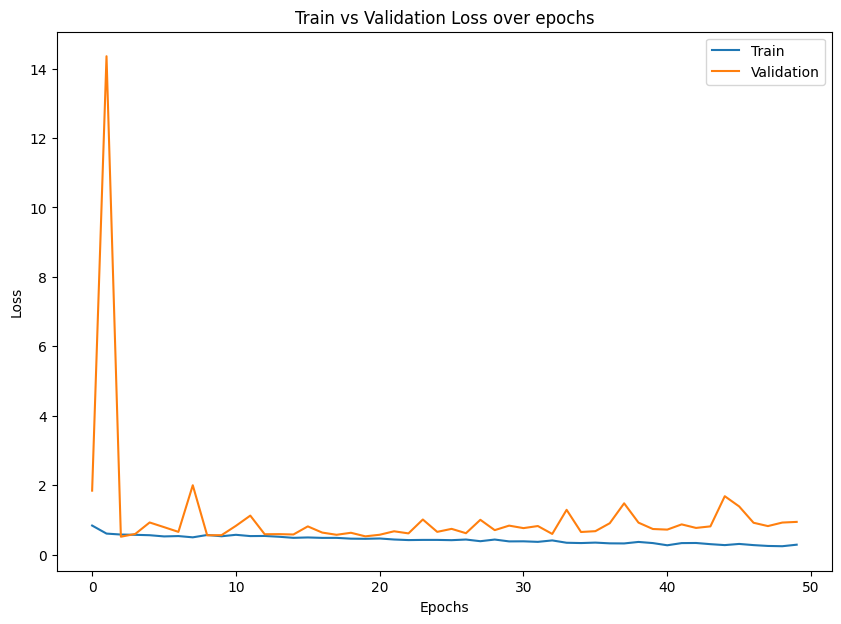

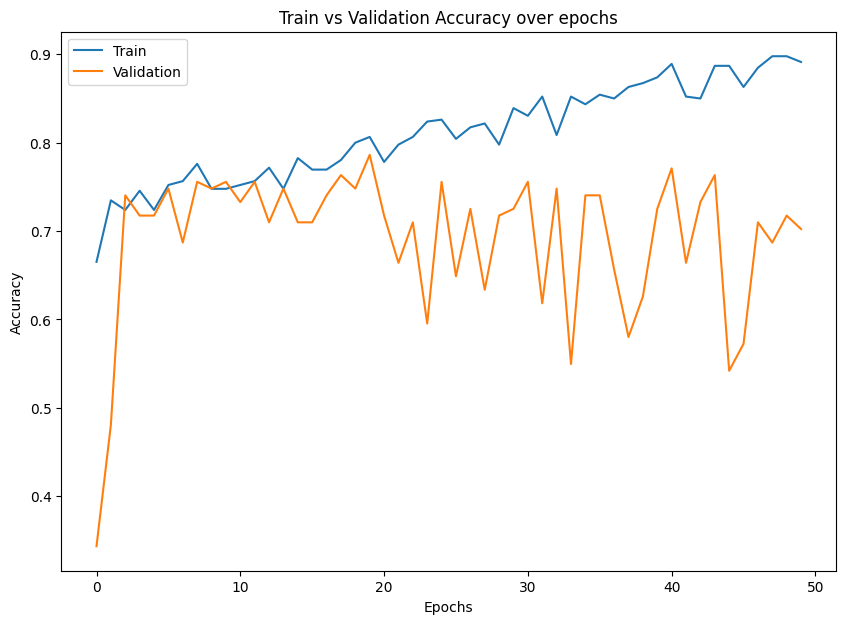

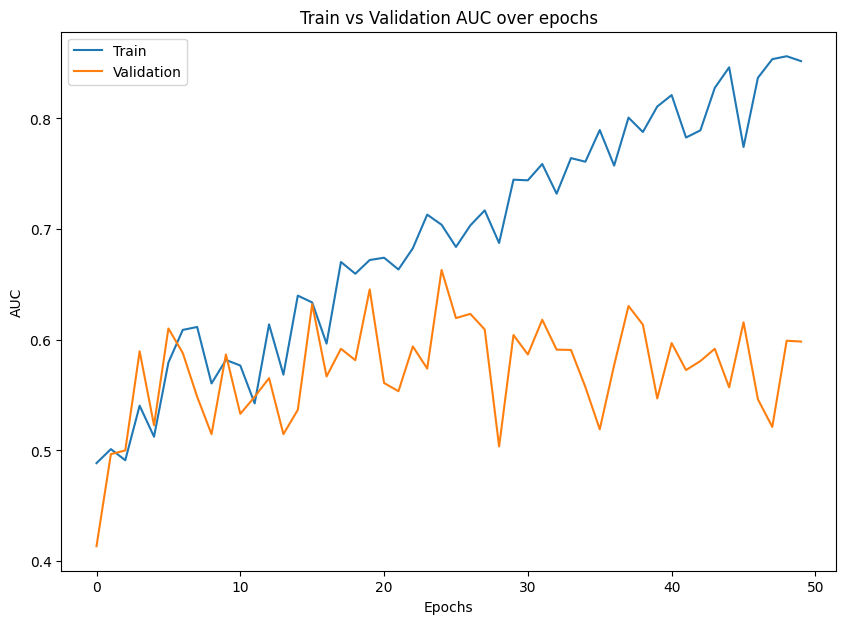

In [47]:
plot_training_results(train_losses_a, train_accs_a, train_aucs_a, val_losses_a, val_accs_a, val_aucs_a)

**Model B** : DenseNet121 with 0.1 dropout rate

In [48]:
#Train and evaluate the model
train_losses_b, train_accs_b, val_losses_b, val_accs_b, train_aucs_b, val_aucs_b  = train_and_eval_s(model_2, train_loader, val_loader, criterion, optimizer_3, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0)

Epoch 1/50: 100%|██████████| 15/15 [01:57<00:00,  7.87s/it, loss=0.548]


Epoch 1/50
Train Loss: 0.8761, Train Acc: 0.5087, Train AUC: 0.5099
Val Loss: 0.6444, Val Acc: 0.6565, Val AUC: 0.5675
Model with best validation accuracy saved at epoch 0 with 0.6565 accuracy!


Epoch 2/50: 100%|██████████| 15/15 [01:57<00:00,  7.82s/it, loss=0.944]


Epoch 2/50
Train Loss: 0.8314, Train Acc: 0.5348, Train AUC: 0.5462
Val Loss: 0.7054, Val Acc: 0.6107, Val AUC: 0.5556


Epoch 3/50: 100%|██████████| 15/15 [01:57<00:00,  7.83s/it, loss=0.615]


Epoch 3/50
Train Loss: 0.8691, Train Acc: 0.5174, Train AUC: 0.5238
Val Loss: 0.8454, Val Acc: 0.5115, Val AUC: 0.4886


Epoch 4/50: 100%|██████████| 15/15 [01:55<00:00,  7.73s/it, loss=0.975]


Epoch 4/50
Train Loss: 0.8111, Train Acc: 0.5348, Train AUC: 0.5462
Val Loss: 0.8718, Val Acc: 0.5573, Val AUC: 0.4909


Epoch 5/50: 100%|██████████| 15/15 [01:57<00:00,  7.81s/it, loss=0.683]


Epoch 5/50
Train Loss: 0.8189, Train Acc: 0.5478, Train AUC: 0.5657
Val Loss: 0.8951, Val Acc: 0.5191, Val AUC: 0.5224


Epoch 6/50: 100%|██████████| 15/15 [01:57<00:00,  7.85s/it, loss=0.553]


Epoch 6/50
Train Loss: 0.8146, Train Acc: 0.5565, Train AUC: 0.5636
Val Loss: 0.8711, Val Acc: 0.5115, Val AUC: 0.4982


Epoch 7/50: 100%|██████████| 15/15 [01:57<00:00,  7.81s/it, loss=0.916]


Epoch 7/50
Train Loss: 0.8602, Train Acc: 0.5348, Train AUC: 0.5409
Val Loss: 0.8503, Val Acc: 0.5802, Val AUC: 0.5446


Epoch 8/50: 100%|██████████| 15/15 [01:56<00:00,  7.78s/it, loss=0.739]


Epoch 8/50
Train Loss: 0.8942, Train Acc: 0.5130, Train AUC: 0.5128
Val Loss: 0.8149, Val Acc: 0.5878, Val AUC: 0.5497


Epoch 9/50: 100%|██████████| 15/15 [01:58<00:00,  7.88s/it, loss=1.03] 


Epoch 9/50
Train Loss: 0.8622, Train Acc: 0.5413, Train AUC: 0.5373
Val Loss: 0.8086, Val Acc: 0.5878, Val AUC: 0.5402


Epoch 10/50: 100%|██████████| 15/15 [01:58<00:00,  7.92s/it, loss=0.784]


Epoch 10/50
Train Loss: 0.8605, Train Acc: 0.5413, Train AUC: 0.5506
Val Loss: 0.8693, Val Acc: 0.5420, Val AUC: 0.5188


Epoch 11/50: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it, loss=0.784]


Epoch 11/50
Train Loss: 0.8241, Train Acc: 0.5543, Train AUC: 0.5754
Val Loss: 0.7807, Val Acc: 0.5802, Val AUC: 0.5732


Epoch 12/50: 100%|██████████| 15/15 [01:59<00:00,  7.95s/it, loss=0.854]


Epoch 12/50
Train Loss: 0.8807, Train Acc: 0.5370, Train AUC: 0.5344
Val Loss: 0.8130, Val Acc: 0.5267, Val AUC: 0.4798


Epoch 13/50: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it, loss=1.16] 


Epoch 13/50
Train Loss: 0.8449, Train Acc: 0.5413, Train AUC: 0.5426
Val Loss: 0.8336, Val Acc: 0.5725, Val AUC: 0.5394


Epoch 14/50: 100%|██████████| 15/15 [01:58<00:00,  7.90s/it, loss=0.793]


Epoch 14/50
Train Loss: 0.8361, Train Acc: 0.5609, Train AUC: 0.5719
Val Loss: 0.8201, Val Acc: 0.5573, Val AUC: 0.5387


Epoch 15/50: 100%|██████████| 15/15 [02:00<00:00,  8.00s/it, loss=1.25] 


Epoch 15/50
Train Loss: 0.9087, Train Acc: 0.5261, Train AUC: 0.5350
Val Loss: 0.9125, Val Acc: 0.5115, Val AUC: 0.5077


Epoch 16/50: 100%|██████████| 15/15 [02:00<00:00,  8.01s/it, loss=0.65] 


Epoch 16/50
Train Loss: 0.8668, Train Acc: 0.5065, Train AUC: 0.5137
Val Loss: 0.8471, Val Acc: 0.5573, Val AUC: 0.5387


Epoch 17/50: 100%|██████████| 15/15 [02:00<00:00,  8.03s/it, loss=0.753]


Epoch 17/50
Train Loss: 0.8382, Train Acc: 0.5652, Train AUC: 0.5828
Val Loss: 0.8521, Val Acc: 0.5344, Val AUC: 0.5518


Epoch 18/50: 100%|██████████| 15/15 [01:59<00:00,  7.99s/it, loss=0.814]


Epoch 18/50
Train Loss: 0.8596, Train Acc: 0.5304, Train AUC: 0.5299
Val Loss: 0.8548, Val Acc: 0.5496, Val AUC: 0.4953


Epoch 19/50: 100%|██████████| 15/15 [02:00<00:00,  8.01s/it, loss=0.484]


Epoch 19/50
Train Loss: 0.8553, Train Acc: 0.5283, Train AUC: 0.5444
Val Loss: 0.8806, Val Acc: 0.5267, Val AUC: 0.5180


Epoch 20/50: 100%|██████████| 15/15 [01:59<00:00,  8.00s/it, loss=0.931]


Epoch 20/50
Train Loss: 0.8866, Train Acc: 0.5174, Train AUC: 0.5238
Val Loss: 0.8001, Val Acc: 0.5420, Val AUC: 0.5570


Epoch 21/50: 100%|██████████| 15/15 [01:59<00:00,  8.00s/it, loss=0.913]


Epoch 21/50
Train Loss: 0.8652, Train Acc: 0.5283, Train AUC: 0.5232
Val Loss: 0.9120, Val Acc: 0.5038, Val AUC: 0.5026


Epoch 22/50: 100%|██████████| 15/15 [02:00<00:00,  8.00s/it, loss=0.894]


Epoch 22/50
Train Loss: 0.8518, Train Acc: 0.5239, Train AUC: 0.5388
Val Loss: 0.8328, Val Acc: 0.5573, Val AUC: 0.5291


Epoch 23/50: 100%|██████████| 15/15 [01:59<00:00,  7.98s/it, loss=0.518]


Epoch 23/50
Train Loss: 0.7940, Train Acc: 0.5652, Train AUC: 0.5828
Val Loss: 0.8285, Val Acc: 0.5420, Val AUC: 0.5188


Epoch 24/50: 100%|██████████| 15/15 [01:58<00:00,  7.93s/it, loss=0.821]


Epoch 24/50
Train Loss: 0.8483, Train Acc: 0.5326, Train AUC: 0.5314
Val Loss: 0.9072, Val Acc: 0.5115, Val AUC: 0.4791


Epoch 25/50: 100%|██████████| 15/15 [01:58<00:00,  7.92s/it, loss=0.878]


Epoch 25/50
Train Loss: 0.8465, Train Acc: 0.5152, Train AUC: 0.5196
Val Loss: 0.8607, Val Acc: 0.5802, Val AUC: 0.5637


Epoch 26/50: 100%|██████████| 15/15 [01:58<00:00,  7.93s/it, loss=0.983]


Epoch 26/50
Train Loss: 0.8671, Train Acc: 0.5174, Train AUC: 0.5211
Val Loss: 0.8627, Val Acc: 0.6183, Val AUC: 0.6181


Epoch 27/50: 100%|██████████| 15/15 [01:58<00:00,  7.92s/it, loss=0.807]


Epoch 27/50
Train Loss: 0.8611, Train Acc: 0.5130, Train AUC: 0.5182
Val Loss: 0.8519, Val Acc: 0.5496, Val AUC: 0.5335


Epoch 28/50: 100%|██████████| 15/15 [01:58<00:00,  7.90s/it, loss=0.964]


Epoch 28/50
Train Loss: 0.8733, Train Acc: 0.5304, Train AUC: 0.5353
Val Loss: 0.8256, Val Acc: 0.5496, Val AUC: 0.4953


Epoch 29/50: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it, loss=0.754]


Epoch 29/50
Train Loss: 0.8219, Train Acc: 0.5304, Train AUC: 0.5406
Val Loss: 0.8427, Val Acc: 0.5420, Val AUC: 0.5092


Epoch 30/50: 100%|██████████| 15/15 [01:59<00:00,  7.99s/it, loss=0.486]


Epoch 30/50
Train Loss: 0.8644, Train Acc: 0.5130, Train AUC: 0.5261
Val Loss: 0.9011, Val Acc: 0.5115, Val AUC: 0.5173


Epoch 31/50: 100%|██████████| 15/15 [01:58<00:00,  7.93s/it, loss=0.895]


Epoch 31/50
Train Loss: 0.8609, Train Acc: 0.5304, Train AUC: 0.5379
Val Loss: 0.8855, Val Acc: 0.5267, Val AUC: 0.5276


Epoch 32/50: 100%|██████████| 15/15 [01:58<00:00,  7.90s/it, loss=1.08] 


Epoch 32/50
Train Loss: 0.8803, Train Acc: 0.5109, Train AUC: 0.5273
Val Loss: 0.9017, Val Acc: 0.5725, Val AUC: 0.5299


Epoch 33/50: 100%|██████████| 15/15 [01:58<00:00,  7.92s/it, loss=1.09] 


Epoch 33/50
Train Loss: 0.8765, Train Acc: 0.5043, Train AUC: 0.5149
Val Loss: 0.7887, Val Acc: 0.5725, Val AUC: 0.5776


Epoch 34/50: 100%|██████████| 15/15 [01:59<00:00,  7.97s/it, loss=0.891]


Epoch 34/50
Train Loss: 0.8496, Train Acc: 0.5326, Train AUC: 0.5341
Val Loss: 0.8933, Val Acc: 0.5496, Val AUC: 0.5240


Epoch 35/50: 100%|██████████| 15/15 [01:59<00:00,  7.94s/it, loss=0.821]


Epoch 35/50
Train Loss: 0.8490, Train Acc: 0.5587, Train AUC: 0.5677
Val Loss: 0.8727, Val Acc: 0.4809, Val AUC: 0.4776


Epoch 36/50: 100%|██████████| 15/15 [01:58<00:00,  7.93s/it, loss=0.719]


Epoch 36/50
Train Loss: 0.9006, Train Acc: 0.4891, Train AUC: 0.4886
Val Loss: 0.7786, Val Acc: 0.5649, Val AUC: 0.5629


Epoch 37/50: 100%|██████████| 15/15 [01:58<00:00,  7.89s/it, loss=0.854]


Epoch 37/50
Train Loss: 0.8433, Train Acc: 0.5109, Train AUC: 0.5193
Val Loss: 0.8096, Val Acc: 0.5649, Val AUC: 0.5534


Epoch 38/50: 100%|██████████| 15/15 [01:59<00:00,  7.94s/it, loss=0.842]


Epoch 38/50
Train Loss: 0.8376, Train Acc: 0.5304, Train AUC: 0.5406
Val Loss: 0.9159, Val Acc: 0.5191, Val AUC: 0.4651


Epoch 39/50: 100%|██████████| 15/15 [01:59<00:00,  7.94s/it, loss=1.06] 


Epoch 39/50
Train Loss: 0.8166, Train Acc: 0.5391, Train AUC: 0.5545
Val Loss: 0.9496, Val Acc: 0.5115, Val AUC: 0.4791


Epoch 40/50: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it, loss=0.865]


Epoch 40/50
Train Loss: 0.8443, Train Acc: 0.5196, Train AUC: 0.5305
Val Loss: 0.8638, Val Acc: 0.5420, Val AUC: 0.4997


Epoch 41/50: 100%|██████████| 15/15 [01:59<00:00,  7.98s/it, loss=1.2]  


Epoch 41/50
Train Loss: 0.8669, Train Acc: 0.5043, Train AUC: 0.5202
Val Loss: 0.8201, Val Acc: 0.5191, Val AUC: 0.4842


Epoch 42/50: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it, loss=0.639]


Epoch 42/50
Train Loss: 0.8367, Train Acc: 0.5630, Train AUC: 0.5707
Val Loss: 0.7860, Val Acc: 0.5649, Val AUC: 0.5629


Epoch 43/50: 100%|██████████| 15/15 [01:59<00:00,  7.99s/it, loss=0.752]


Epoch 43/50
Train Loss: 0.7944, Train Acc: 0.5804, Train AUC: 0.5904
Val Loss: 0.8542, Val Acc: 0.5649, Val AUC: 0.5534


Epoch 44/50: 100%|██████████| 15/15 [01:58<00:00,  7.92s/it, loss=0.825]


Epoch 44/50
Train Loss: 0.8367, Train Acc: 0.5283, Train AUC: 0.5311
Val Loss: 0.8767, Val Acc: 0.5191, Val AUC: 0.4938


Epoch 45/50: 100%|██████████| 15/15 [01:59<00:00,  7.95s/it, loss=0.791]


Epoch 45/50
Train Loss: 0.8403, Train Acc: 0.5391, Train AUC: 0.5571
Val Loss: 0.9227, Val Acc: 0.4885, Val AUC: 0.4827


Epoch 46/50: 100%|██████████| 15/15 [01:58<00:00,  7.90s/it, loss=0.36] 


Epoch 46/50
Train Loss: 0.8518, Train Acc: 0.5370, Train AUC: 0.5450
Val Loss: 0.8691, Val Acc: 0.5954, Val AUC: 0.5644


Epoch 47/50: 100%|██████████| 15/15 [01:58<00:00,  7.91s/it, loss=0.842]


Epoch 47/50
Train Loss: 0.8180, Train Acc: 0.5413, Train AUC: 0.5426
Val Loss: 0.9074, Val Acc: 0.5496, Val AUC: 0.4953


Epoch 48/50: 100%|██████████| 15/15 [01:57<00:00,  7.86s/it, loss=0.76] 
python(15213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 48/50
Train Loss: 0.8890, Train Acc: 0.5022, Train AUC: 0.5055
Val Loss: 0.8068, Val Acc: 0.5725, Val AUC: 0.5681


  0%|          | 0/15 [00:00<?, ?it/s]python(15223) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15224) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15226) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 49/50: 100%|██████████| 15/15 [01:58<00:00,  7.88s/it, loss=0.92] 
python(15283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 49/50
Train Loss: 0.8660, Train Acc: 0.5326, Train AUC: 0.5341
Val Loss: 0.8239, Val Acc: 0.5573, Val AUC: 0.5482


  0%|          | 0/15 [00:00<?, ?it/s]python(15292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15293) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15294) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 50/50: 100%|██████████| 15/15 [01:57<00:00,  7.84s/it, loss=1.05] 
python(15315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15317) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15318) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 50/50
Train Loss: 0.8201, Train Acc: 0.5587, Train AUC: 0.5677
Val Loss: 0.9331, Val Acc: 0.5038, Val AUC: 0.5026


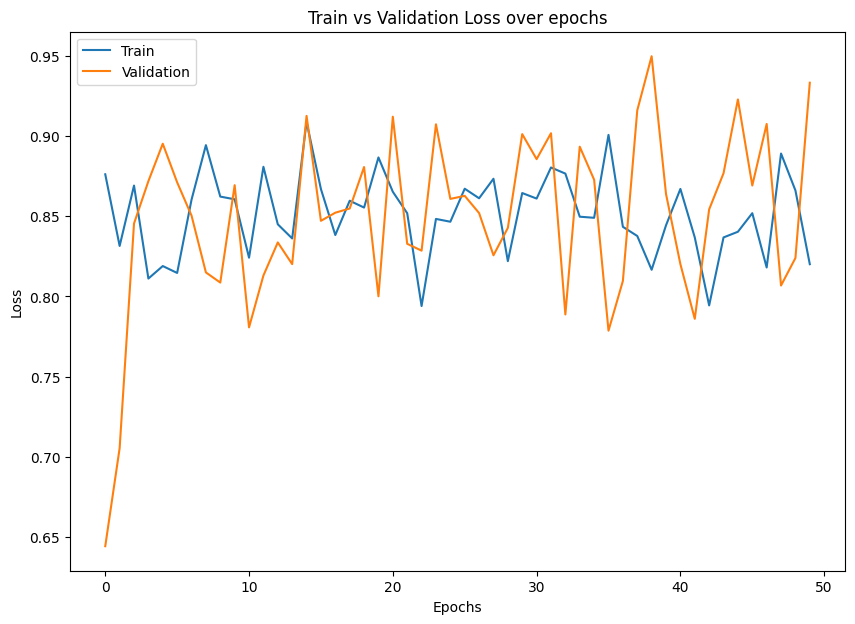

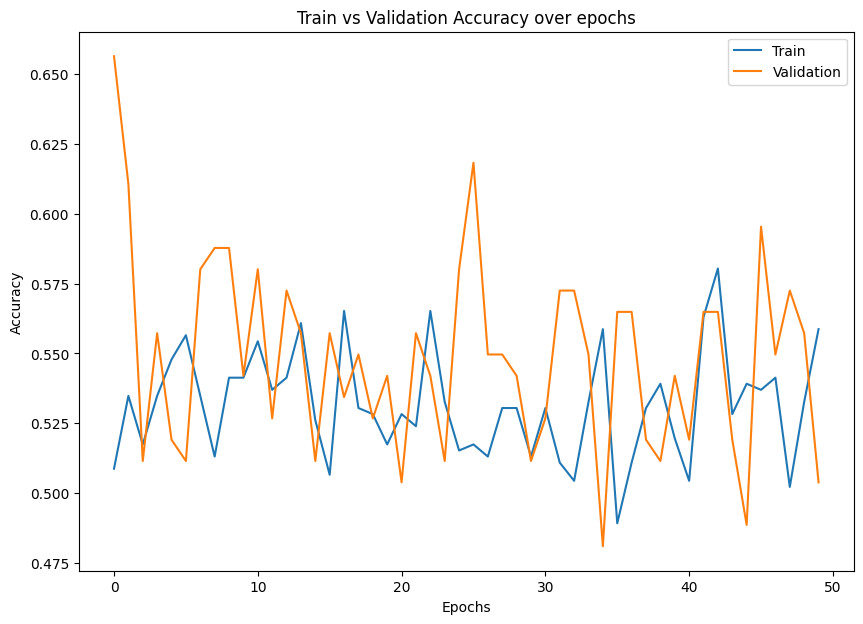

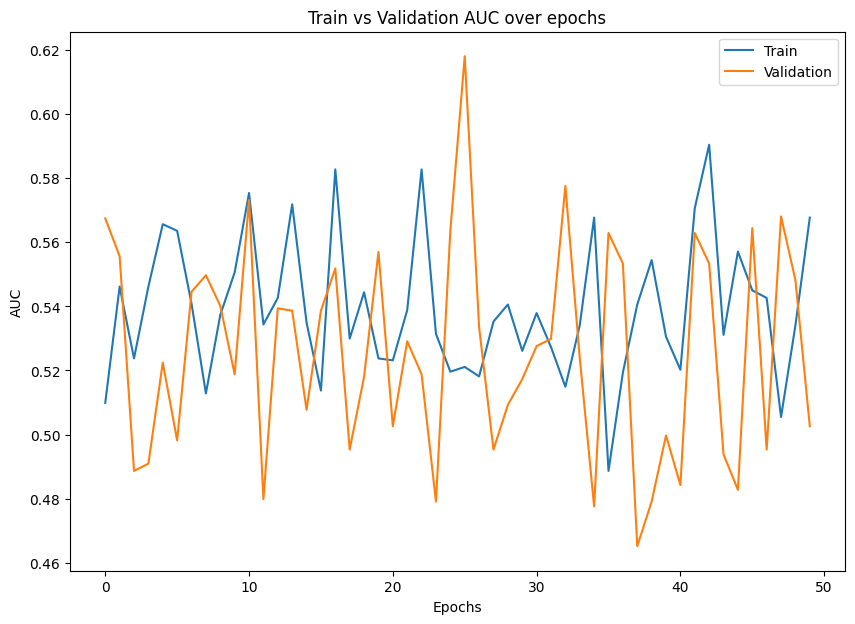

In [49]:
plot_training_results(train_losses_b, train_accs_b, train_aucs_b, val_losses_b, val_accs_b, val_aucs_b)

In [28]:
def plot_confusion_matrix(model, model_path, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load the entire dictionary from the specified file
    checkpoint = torch.load(model_path)
    
    # Load the state_dict into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model = model.to(device)
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

This confusion matrix code takes in three arguments: the model, the path to the model, and the data loader.
The function loads the model from the specified path, evaluates it on the data loader, and computes the confusion matrix.
Finally, it plots the confusion matrix using seaborn's heatmap function.

The cell at the intersection of the first row and the first column (top-left cell) represents the number of true negatives (TN), i.e., the number of instances where the model correctly predicted class 0.

The cell at the intersection of the first row and the second column (top-right cell) represents the number of false positives (FP), i.e., the number of instances where the model incorrectly predicted class 1.

The cell at the intersection of the second row and the first column (bottom-left cell) represents the number of false negatives (FN), i.e., the number of instances where the model incorrectly predicted class 0.

The cell at the intersection of the second row and the second column (bottom-right cell) represents the number of true positives (TP), i.e., the number of instances where the model correctly predicted class 1.

In this usage, it is better to have false positives than false negatives as the lack of early treatmnet can cost a patient's life. 


/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1330/2408048868.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


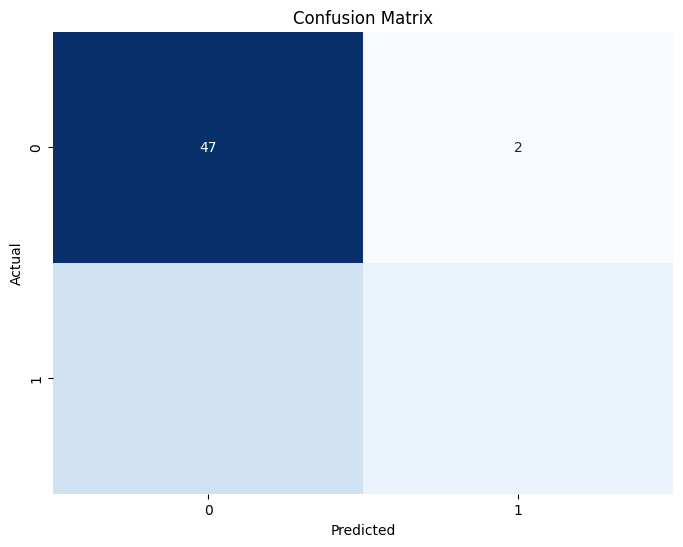

In [32]:
#Confusion matrix for model A: resnet50 with 0.1 dropout rate
plot_confusion_matrix(model_1, '../notebooks/best_model_20240813-004135.pth', test_loader)

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1013/2408048868.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


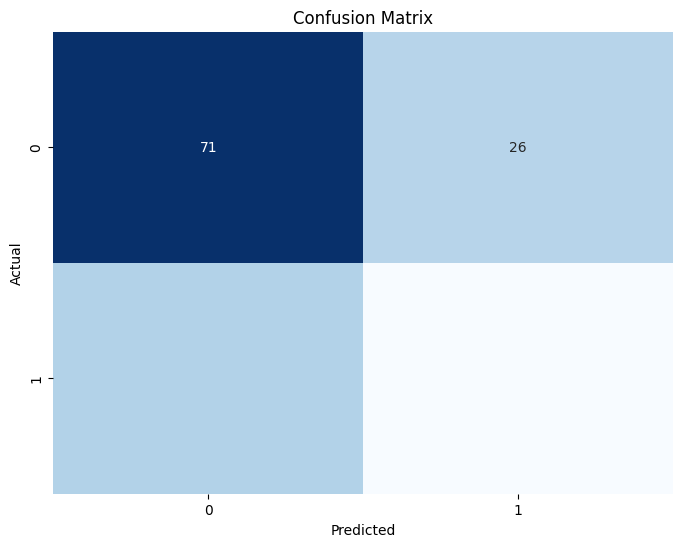

In [35]:
#Confusion matrix for model B: densenet with dropout rate of 0.1
plot_confusion_matrix(model_2, '../notebooks/best_model_20240813-015436.pth', val_loader)

More false positives than false negatives 
This means that the model is more likely to predict a malignant lesion when it is not malignant than to predict a non-malignant lesion when it is malignant
This could be due to the class imbalance in the dataset
A way of addressing this issue is to use class weights in the loss function
This will penalize the model more for misclassifying the minority class (malignant) than the majority class (non-malignant)


In [29]:
#We can see that the model is overfitting, we can try to add more regularization techniques to prevent overfitting
#Model C - Resnet50 with dropout and batch normalization
model_3 = SkinLesionModel_resnet(dropout_rate=0.3)
#Model D - Custom DenseNet121 with dropout and batch normalization
model_4 = CustomDenseNet121(dropout_rate=0.3)

Resnet created with 2 classes and dropout rate of 0.3
DenseNet121 created with 2 classes and dropout rate of 0.3
Model has 7249796 trainable params.


In [30]:
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.001)


## Transfer learning and evaluation 

### Evaluating CNN Models with Diverse Dropout rates

The purpose of testing differnet confugurations of the pre-trained CNN models is to evaluate the impact of varying dropout rates on the model's performance. 

By experimenting with these hyperparameters, I aim to identify the optimal settings for the best generalization performance on the skin cancer detection task. 

| Model | Architecture | Dropout Rate | Purpose |
|-------|--------------|--------------|---------|
| A     | ResNet       | 0.1          | Assess performance with minimal regularization; potential overfitting. |
| B     | DenseNet      | 0.1          |  Investigate DenseNet's performance with minimal regularization; potential overfitting.|
| C     | ResNet        | 0.3          |  Evaluate balance between regularization and learning; moderate dropout rate.|
| D     | DenseNet     | 0.3          | Evaluate DenseNet's balance between regularization and learning; moderate dropout rate. |
| E     | ResNet       | 0.3          | Evaluate ResNet's performance with class weights accounted for in the loss function. Moderate dropout rate|
| F     | DenseNet     | 0.3          | Evaluate DenseNet's performance with class weights accounted for in the loss function. Moderate dropout rate |

Expected Outcomes:

- Model A & B: High training accuracy, lower validation accuracy due to overfitting. These models have a lower dropout rate, which means less regularization and a higher chance of overfitting to the training data.

- Model C & D: Balanced training and validation accuracy, indicating good generalization. These models have a moderate dropout rate, which provides a balance between learning from the data and regularization, helping the model to generalize better to unseen data.

- Models E and F are similar to B and D respectively, but with class weights accounted for in the loss function. 


In [39]:
#Train and evaluate the model C
train_losses_c, train_accs_c, val_losses_c, val_accs_c, train_aucs_c, val_aucs_c  = train_and_eval_s(model_3, train_loader, val_loader, criterion, optimizer_3, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0)

Epoch 1/50: 100%|██████████| 15/15 [01:41<00:00,  6.76s/it, loss=0.64] 


Epoch 1/50
Train Loss: 0.7255, Train Acc: 0.6783, Train AUC: 0.5054
Val Loss: 47.3177, Val Acc: 0.2672, Val AUC: 0.5052
Model with best validation accuracy saved at epoch 0 with 0.2672 accuracy!


Epoch 2/50: 100%|██████████| 15/15 [01:44<00:00,  6.97s/it, loss=0.915]


Epoch 2/50
Train Loss: 0.6109, Train Acc: 0.7130, Train AUC: 0.5263
Val Loss: 2.5886, Val Acc: 0.4809, Val AUC: 0.5158
Model with best validation accuracy saved at epoch 1 with 0.4809 accuracy!


Epoch 3/50: 100%|██████████| 15/15 [01:42<00:00,  6.84s/it, loss=1.49] 
/opt/miniconda3/envs/test1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/50
Train Loss: 0.6000, Train Acc: 0.7304, Train AUC: 0.5594
Val Loss: 0.5893, Val Acc: 0.7405, Val AUC: 0.5000
Model with best validation accuracy saved at epoch 2 with 0.7405 accuracy!


Epoch 4/50: 100%|██████████| 15/15 [01:44<00:00,  6.95s/it, loss=0.661]


Epoch 4/50
Train Loss: 0.5542, Train Acc: 0.7391, Train AUC: 0.5360
Val Loss: 1.2155, Val Acc: 0.6031, Val AUC: 0.5505


Epoch 5/50: 100%|██████████| 15/15 [01:46<00:00,  7.08s/it, loss=0.615]
/opt/miniconda3/envs/test1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/50
Train Loss: 0.5398, Train Acc: 0.7565, Train AUC: 0.5638
Val Loss: 0.5900, Val Acc: 0.7405, Val AUC: 0.5000


Epoch 6/50: 100%|██████████| 15/15 [01:48<00:00,  7.20s/it, loss=0.456]


Epoch 6/50
Train Loss: 0.5424, Train Acc: 0.7283, Train AUC: 0.5180
Val Loss: 0.5503, Val Acc: 0.7481, Val AUC: 0.5911
Model with best validation accuracy saved at epoch 5 with 0.7481 accuracy!


Epoch 7/50: 100%|██████████| 15/15 [01:47<00:00,  7.19s/it, loss=0.528]


Epoch 7/50
Train Loss: 0.5163, Train Acc: 0.7717, Train AUC: 0.6139
Val Loss: 0.6352, Val Acc: 0.7252, Val AUC: 0.6139


Epoch 8/50: 100%|██████████| 15/15 [01:45<00:00,  7.03s/it, loss=0.603]


Epoch 8/50
Train Loss: 0.5233, Train Acc: 0.7717, Train AUC: 0.6193
Val Loss: 0.5524, Val Acc: 0.7481, Val AUC: 0.5529


Epoch 9/50: 100%|██████████| 15/15 [01:47<00:00,  7.16s/it, loss=0.451]


Epoch 9/50
Train Loss: 0.4904, Train Acc: 0.7848, Train AUC: 0.6255
Val Loss: 0.6709, Val Acc: 0.6947, Val AUC: 0.5550


Epoch 10/50: 100%|██████████| 15/15 [01:45<00:00,  7.06s/it, loss=0.407]


Epoch 10/50
Train Loss: 0.4875, Train Acc: 0.7630, Train AUC: 0.6187
Val Loss: 0.6342, Val Acc: 0.7252, Val AUC: 0.6425


Epoch 11/50: 100%|██████████| 15/15 [01:57<00:00,  7.81s/it, loss=0.462]


Epoch 11/50
Train Loss: 0.4827, Train Acc: 0.7783, Train AUC: 0.6237
Val Loss: 0.6764, Val Acc: 0.7252, Val AUC: 0.5279


Epoch 12/50: 100%|██████████| 15/15 [01:52<00:00,  7.51s/it, loss=0.262]


Epoch 12/50
Train Loss: 0.4704, Train Acc: 0.7739, Train AUC: 0.6367
Val Loss: 0.5695, Val Acc: 0.7557, Val AUC: 0.5676
Model with best validation accuracy saved at epoch 11 with 0.7557 accuracy!


Epoch 13/50: 100%|██████████| 15/15 [01:52<00:00,  7.47s/it, loss=0.222]


Epoch 13/50
Train Loss: 0.4735, Train Acc: 0.7739, Train AUC: 0.6579
Val Loss: 0.7063, Val Acc: 0.7405, Val AUC: 0.5382


Epoch 14/50: 100%|██████████| 15/15 [01:45<00:00,  7.03s/it, loss=0.271]


Epoch 14/50
Train Loss: 0.4991, Train Acc: 0.8043, Train AUC: 0.7078
Val Loss: 0.6726, Val Acc: 0.6947, Val AUC: 0.6314


Epoch 15/50: 100%|██████████| 15/15 [01:46<00:00,  7.08s/it, loss=0.503]


Epoch 15/50
Train Loss: 0.5061, Train Acc: 0.7717, Train AUC: 0.6352
Val Loss: 0.8316, Val Acc: 0.7328, Val AUC: 0.5044


Epoch 16/50: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it, loss=0.345]


Epoch 16/50
Train Loss: 0.4903, Train Acc: 0.7826, Train AUC: 0.6346
Val Loss: 0.5945, Val Acc: 0.7481, Val AUC: 0.5720


Epoch 17/50: 100%|██████████| 15/15 [01:47<00:00,  7.16s/it, loss=0.71] 


Epoch 17/50
Train Loss: 0.4690, Train Acc: 0.7935, Train AUC: 0.6340
Val Loss: 0.6425, Val Acc: 0.7557, Val AUC: 0.5390


Epoch 18/50: 100%|██████████| 15/15 [01:48<00:00,  7.26s/it, loss=0.326]


Epoch 18/50
Train Loss: 0.4481, Train Acc: 0.7804, Train AUC: 0.6597
Val Loss: 1.0411, Val Acc: 0.6107, Val AUC: 0.6034


Epoch 19/50: 100%|██████████| 15/15 [01:45<00:00,  7.06s/it, loss=0.548]


Epoch 19/50
Train Loss: 0.4050, Train Acc: 0.8196, Train AUC: 0.7235
Val Loss: 1.4361, Val Acc: 0.7557, Val AUC: 0.5294


Epoch 20/50: 100%|██████████| 15/15 [01:48<00:00,  7.25s/it, loss=0.275]


Epoch 20/50
Train Loss: 0.4378, Train Acc: 0.8000, Train AUC: 0.6916
Val Loss: 0.6868, Val Acc: 0.7481, Val AUC: 0.6293


Epoch 21/50: 100%|██████████| 15/15 [01:56<00:00,  7.75s/it, loss=0.662]


Epoch 21/50
Train Loss: 0.4314, Train Acc: 0.8065, Train AUC: 0.6960
Val Loss: 0.6149, Val Acc: 0.7481, Val AUC: 0.6007


Epoch 22/50: 100%|██████████| 15/15 [01:51<00:00,  7.40s/it, loss=0.522]


Epoch 22/50
Train Loss: 0.4675, Train Acc: 0.8000, Train AUC: 0.6624
Val Loss: 0.5766, Val Acc: 0.7634, Val AUC: 0.5919
Model with best validation accuracy saved at epoch 21 with 0.7634 accuracy!


Epoch 23/50: 100%|██████████| 15/15 [02:06<00:00,  8.44s/it, loss=0.967]


Epoch 23/50
Train Loss: 0.4632, Train Acc: 0.7913, Train AUC: 0.6777
Val Loss: 0.6031, Val Acc: 0.7634, Val AUC: 0.6301


Epoch 24/50: 100%|██████████| 15/15 [01:58<00:00,  7.88s/it, loss=0.23] 


Epoch 24/50
Train Loss: 0.4704, Train Acc: 0.8000, Train AUC: 0.6889
Val Loss: 0.6206, Val Acc: 0.7405, Val AUC: 0.6146


Epoch 25/50: 100%|██████████| 15/15 [02:11<00:00,  8.73s/it, loss=0.361]


Epoch 25/50
Train Loss: 0.4466, Train Acc: 0.7978, Train AUC: 0.6795
Val Loss: 0.6607, Val Acc: 0.7023, Val AUC: 0.6557


Epoch 26/50: 100%|██████████| 15/15 [02:18<00:00,  9.24s/it, loss=0.589]


Epoch 26/50
Train Loss: 0.4386, Train Acc: 0.7957, Train AUC: 0.6886
Val Loss: 0.6235, Val Acc: 0.7252, Val AUC: 0.5661


Epoch 27/50: 100%|██████████| 15/15 [02:11<00:00,  8.78s/it, loss=0.419]


Epoch 27/50
Train Loss: 0.4447, Train Acc: 0.8109, Train AUC: 0.6910
Val Loss: 0.5455, Val Acc: 0.7557, Val AUC: 0.5772


Epoch 28/50: 100%|██████████| 15/15 [01:48<00:00,  7.23s/it, loss=0.192]


Epoch 28/50
Train Loss: 0.3738, Train Acc: 0.8370, Train AUC: 0.7299
Val Loss: 0.8992, Val Acc: 0.6336, Val AUC: 0.5424


Epoch 29/50: 100%|██████████| 15/15 [01:54<00:00,  7.61s/it, loss=0.323]


Epoch 29/50
Train Loss: 0.3828, Train Acc: 0.8326, Train AUC: 0.7376
Val Loss: 0.5977, Val Acc: 0.7405, Val AUC: 0.6146


Epoch 30/50: 100%|██████████| 15/15 [01:50<00:00,  7.34s/it, loss=0.508]


Epoch 30/50
Train Loss: 0.3560, Train Acc: 0.8500, Train AUC: 0.7574
Val Loss: 0.7305, Val Acc: 0.7634, Val AUC: 0.5919


Epoch 31/50: 100%|██████████| 15/15 [17:30<00:00, 70.05s/it, loss=0.107]


Epoch 31/50
Train Loss: 0.3602, Train Acc: 0.8500, Train AUC: 0.7946
Val Loss: 0.9303, Val Acc: 0.7481, Val AUC: 0.5434


Epoch 32/50: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it, loss=0.248]


Epoch 32/50
Train Loss: 0.4604, Train Acc: 0.7957, Train AUC: 0.6647
Val Loss: 0.5729, Val Acc: 0.7634, Val AUC: 0.5823


Epoch 33/50: 100%|██████████| 15/15 [01:46<00:00,  7.09s/it, loss=0.939]


Epoch 33/50
Train Loss: 0.3670, Train Acc: 0.8391, Train AUC: 0.7261
Val Loss: 0.7287, Val Acc: 0.6718, Val AUC: 0.6446


Epoch 34/50: 100%|██████████| 15/15 [13:07<00:00, 52.49s/it, loss=0.562]  


Epoch 34/50
Train Loss: 0.3531, Train Acc: 0.8543, Train AUC: 0.8108
Val Loss: 0.6999, Val Acc: 0.7405, Val AUC: 0.5955


Epoch 35/50: 100%|██████████| 15/15 [01:44<00:00,  7.00s/it, loss=0.689]


Epoch 35/50
Train Loss: 0.3862, Train Acc: 0.8283, Train AUC: 0.7161
Val Loss: 0.9438, Val Acc: 0.6794, Val AUC: 0.5829


Epoch 36/50: 100%|██████████| 15/15 [01:46<00:00,  7.10s/it, loss=0.624]


Epoch 36/50
Train Loss: 0.3244, Train Acc: 0.8696, Train AUC: 0.8185
Val Loss: 0.7733, Val Acc: 0.7176, Val AUC: 0.6087


Epoch 37/50: 100%|██████████| 15/15 [01:46<00:00,  7.11s/it, loss=1.21] 


Epoch 37/50
Train Loss: 0.3856, Train Acc: 0.8326, Train AUC: 0.7509
Val Loss: 0.7534, Val Acc: 0.7557, Val AUC: 0.5772


Epoch 38/50: 100%|██████████| 15/15 [06:48<00:00, 27.23s/it, loss=0.556]


Epoch 38/50
Train Loss: 0.3982, Train Acc: 0.8065, Train AUC: 0.6694
Val Loss: 0.8427, Val Acc: 0.6947, Val AUC: 0.6028


Epoch 39/50: 100%|██████████| 15/15 [01:44<00:00,  6.99s/it, loss=0.315]


Epoch 39/50
Train Loss: 0.3691, Train Acc: 0.8609, Train AUC: 0.7807
Val Loss: 0.7042, Val Acc: 0.7252, Val AUC: 0.5852


Epoch 40/50: 100%|██████████| 15/15 [01:45<00:00,  7.05s/it, loss=0.271]


Epoch 40/50
Train Loss: 0.3163, Train Acc: 0.8761, Train AUC: 0.7910
Val Loss: 0.6482, Val Acc: 0.7481, Val AUC: 0.6198


Epoch 41/50: 100%|██████████| 15/15 [01:45<00:00,  7.06s/it, loss=0.864]


Epoch 41/50
Train Loss: 0.3388, Train Acc: 0.8652, Train AUC: 0.7969
Val Loss: 0.9139, Val Acc: 0.7634, Val AUC: 0.6301


Epoch 42/50: 100%|██████████| 15/15 [01:43<00:00,  6.93s/it, loss=0.333]


Epoch 42/50
Train Loss: 0.3484, Train Acc: 0.8543, Train AUC: 0.8029
Val Loss: 0.8557, Val Acc: 0.7481, Val AUC: 0.6007


Epoch 43/50: 100%|██████████| 15/15 [01:49<00:00,  7.31s/it, loss=0.176]


Epoch 43/50
Train Loss: 0.3228, Train Acc: 0.8565, Train AUC: 0.7857
Val Loss: 1.0227, Val Acc: 0.6870, Val AUC: 0.6454


Epoch 44/50: 100%|██████████| 15/15 [01:50<00:00,  7.34s/it, loss=0.207]


Epoch 44/50
Train Loss: 0.2783, Train Acc: 0.8804, Train AUC: 0.8126
Val Loss: 0.7951, Val Acc: 0.7099, Val AUC: 0.6131


Epoch 45/50: 100%|██████████| 15/15 [01:49<00:00,  7.28s/it, loss=0.511] 


Epoch 45/50
Train Loss: 0.2476, Train Acc: 0.9000, Train AUC: 0.8551
Val Loss: 0.7290, Val Acc: 0.7863, Val AUC: 0.6455
Model with best validation accuracy saved at epoch 44 with 0.7863 accuracy!


Epoch 46/50: 100%|██████████| 15/15 [01:49<00:00,  7.28s/it, loss=0.208]


Epoch 46/50
Train Loss: 0.2361, Train Acc: 0.9087, Train AUC: 0.8477
Val Loss: 1.3266, Val Acc: 0.6718, Val AUC: 0.6064


Epoch 47/50: 100%|██████████| 15/15 [01:52<00:00,  7.47s/it, loss=0.158]


Epoch 47/50
Train Loss: 0.3143, Train Acc: 0.8674, Train AUC: 0.8144
Val Loss: 1.9885, Val Acc: 0.6412, Val AUC: 0.6145


Epoch 48/50: 100%|██████████| 15/15 [01:45<00:00,  7.06s/it, loss=0.418]


Epoch 48/50
Train Loss: 0.3655, Train Acc: 0.8587, Train AUC: 0.7846
Val Loss: 0.8809, Val Acc: 0.7481, Val AUC: 0.5529


Epoch 49/50: 100%|██████████| 15/15 [01:46<00:00,  7.12s/it, loss=0.374]


Epoch 49/50
Train Loss: 0.3184, Train Acc: 0.8652, Train AUC: 0.7651
Val Loss: 0.6448, Val Acc: 0.7023, Val AUC: 0.5984


Epoch 50/50: 100%|██████████| 15/15 [01:45<00:00,  7.05s/it, loss=0.161]


Epoch 50/50
Train Loss: 0.2488, Train Acc: 0.8870, Train AUC: 0.8383
Val Loss: 0.7624, Val Acc: 0.7481, Val AUC: 0.5911


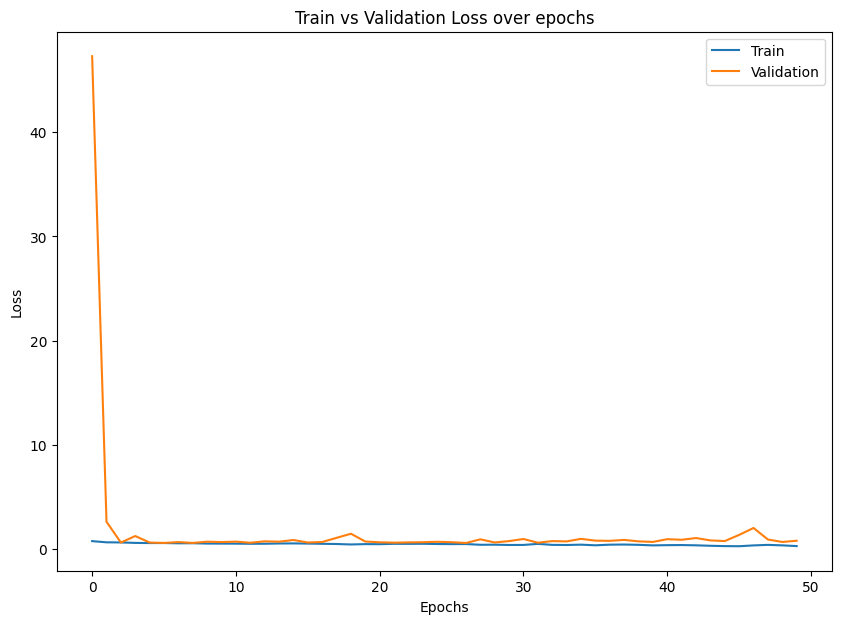

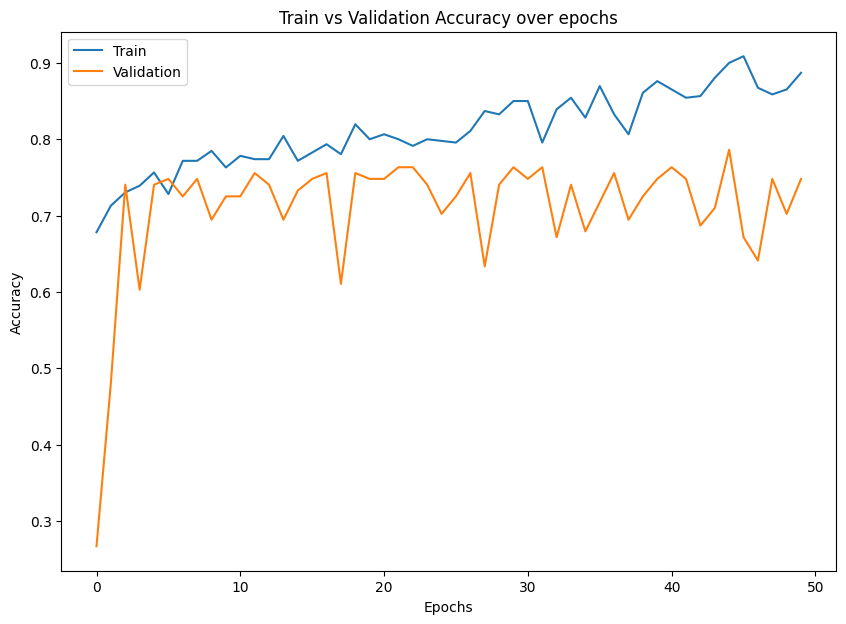

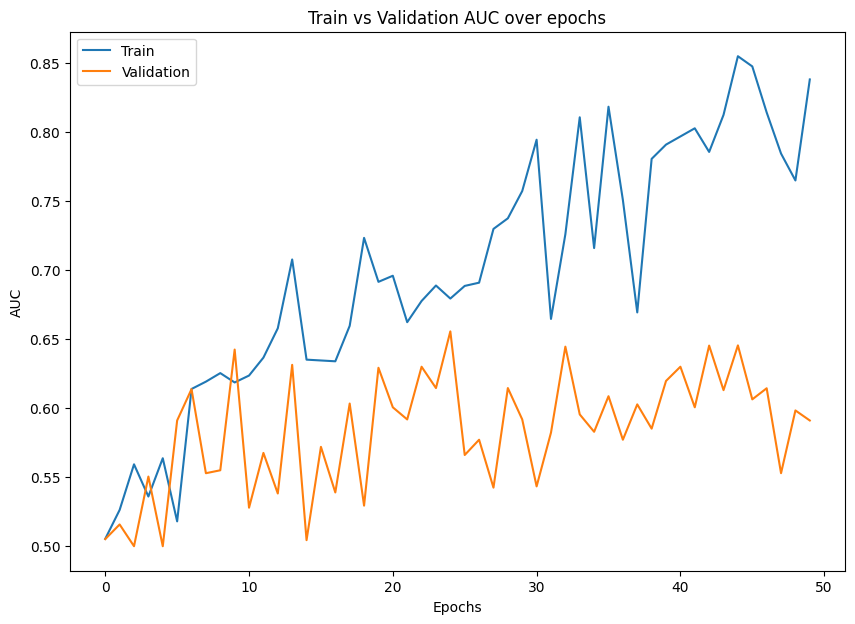

In [40]:
plot_training_results(train_losses_c, train_accs_c, train_aucs_c, val_losses_c, val_accs_c, val_aucs_c)

We can see here that the model is not overfitting as much as the previous models due to the addition of dropout and batch normalization. 
It has acheived an accuracy of 78.6% validation accuracy. 

In [42]:
#Train and evaluate the model D
train_losses_d, train_accs_d, val_losses_d, val_accs_d, train_aucs_d, val_aucs_d  = train_and_eval_s(model_4, train_loader, val_loader, criterion, optimizer_4, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0)

Epoch 1/50: 100%|██████████| 15/15 [01:55<00:00,  7.67s/it, loss=0.802]


Epoch 1/50
Train Loss: 0.8214, Train Acc: 0.5543, Train AUC: 0.5409
Val Loss: 1.3539, Val Acc: 0.3817, Val AUC: 0.4965
Model with best validation accuracy saved at epoch 0 with 0.3817 accuracy!


Epoch 2/50: 100%|██████████| 15/15 [02:03<00:00,  8.24s/it, loss=0.707]


Epoch 2/50
Train Loss: 0.6549, Train Acc: 0.6696, Train AUC: 0.6562
Val Loss: 0.8250, Val Acc: 0.4809, Val AUC: 0.5349
Model with best validation accuracy saved at epoch 1 with 0.4809 accuracy!


Epoch 3/50: 100%|██████████| 15/15 [02:05<00:00,  8.39s/it, loss=0.514]


Epoch 3/50
Train Loss: 0.6151, Train Acc: 0.7261, Train AUC: 0.6441
Val Loss: 0.6834, Val Acc: 0.7481, Val AUC: 0.6580
Model with best validation accuracy saved at epoch 2 with 0.7481 accuracy!


Epoch 4/50: 100%|██████████| 15/15 [02:03<00:00,  8.26s/it, loss=0.82] 


Epoch 4/50
Train Loss: 0.6068, Train Acc: 0.7370, Train AUC: 0.6701
Val Loss: 0.8718, Val Acc: 0.6336, Val AUC: 0.5998


Epoch 5/50: 100%|██████████| 15/15 [02:07<00:00,  8.53s/it, loss=0.632]


Epoch 5/50
Train Loss: 0.5840, Train Acc: 0.7457, Train AUC: 0.6839
Val Loss: 0.7171, Val Acc: 0.7328, Val AUC: 0.6668


Epoch 6/50: 100%|██████████| 15/15 [02:05<00:00,  8.39s/it, loss=0.689]


Epoch 6/50
Train Loss: 0.5821, Train Acc: 0.7522, Train AUC: 0.6910
Val Loss: 0.5790, Val Acc: 0.7557, Val AUC: 0.6822
Model with best validation accuracy saved at epoch 5 with 0.7557 accuracy!


Epoch 7/50: 100%|██████████| 15/15 [02:05<00:00,  8.34s/it, loss=0.612]


Epoch 7/50
Train Loss: 0.5338, Train Acc: 0.7543, Train AUC: 0.7324
Val Loss: 0.8054, Val Acc: 0.6336, Val AUC: 0.6380


Epoch 8/50: 100%|██████████| 15/15 [02:00<00:00,  8.07s/it, loss=0.47] 


Epoch 8/50
Train Loss: 0.5080, Train Acc: 0.8000, Train AUC: 0.7527
Val Loss: 0.6770, Val Acc: 0.7252, Val AUC: 0.6998


Epoch 9/50: 100%|██████████| 15/15 [06:53<00:00, 27.56s/it, loss=0.432]


Epoch 9/50
Train Loss: 0.5028, Train Acc: 0.8196, Train AUC: 0.7580
Val Loss: 0.5132, Val Acc: 0.7863, Val AUC: 0.6169
Model with best validation accuracy saved at epoch 8 with 0.7863 accuracy!


Epoch 10/50: 100%|██████████| 15/15 [02:04<00:00,  8.32s/it, loss=0.485]


Epoch 10/50
Train Loss: 0.4134, Train Acc: 0.8522, Train AUC: 0.7881
Val Loss: 0.5145, Val Acc: 0.7710, Val AUC: 0.6448


Epoch 11/50: 100%|██████████| 15/15 [02:07<00:00,  8.52s/it, loss=0.982]


Epoch 11/50
Train Loss: 0.4844, Train Acc: 0.8087, Train AUC: 0.7400
Val Loss: 0.6228, Val Acc: 0.7405, Val AUC: 0.6624


Epoch 12/50: 100%|██████████| 15/15 [02:00<00:00,  8.03s/it, loss=0.307]


Epoch 12/50
Train Loss: 0.4575, Train Acc: 0.8196, Train AUC: 0.7686
Val Loss: 0.6520, Val Acc: 0.6718, Val AUC: 0.5682


Epoch 13/50: 100%|██████████| 15/15 [02:02<00:00,  8.20s/it, loss=0.468]


Epoch 13/50
Train Loss: 0.4091, Train Acc: 0.8413, Train AUC: 0.7887
Val Loss: 1.0375, Val Acc: 0.6870, Val AUC: 0.6549


Epoch 14/50: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it, loss=0.889]


Epoch 14/50
Train Loss: 0.4636, Train Acc: 0.8130, Train AUC: 0.7323
Val Loss: 0.5491, Val Acc: 0.7328, Val AUC: 0.6095


Epoch 15/50: 100%|██████████| 15/15 [02:02<00:00,  8.17s/it, loss=0.398]


Epoch 15/50
Train Loss: 0.4278, Train Acc: 0.8522, Train AUC: 0.8014
Val Loss: 0.5378, Val Acc: 0.7557, Val AUC: 0.6918


Epoch 16/50: 100%|██████████| 15/15 [01:59<00:00,  7.94s/it, loss=0.585]


Epoch 16/50
Train Loss: 0.4109, Train Acc: 0.8435, Train AUC: 0.8061
Val Loss: 0.5244, Val Acc: 0.7710, Val AUC: 0.6066


Epoch 17/50: 100%|██████████| 15/15 [02:07<00:00,  8.49s/it, loss=0.508]


Epoch 17/50
Train Loss: 0.3726, Train Acc: 0.8522, Train AUC: 0.8094
Val Loss: 0.9354, Val Acc: 0.6412, Val AUC: 0.6336


Epoch 18/50: 100%|██████████| 15/15 [02:05<00:00,  8.37s/it, loss=0.337]


Epoch 18/50
Train Loss: 0.3526, Train Acc: 0.8717, Train AUC: 0.8253
Val Loss: 0.5187, Val Acc: 0.7863, Val AUC: 0.6742


Epoch 19/50: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it, loss=0.437]


Epoch 19/50
Train Loss: 0.3272, Train Acc: 0.9000, Train AUC: 0.8551
Val Loss: 0.5406, Val Acc: 0.7405, Val AUC: 0.5955


Epoch 20/50: 100%|██████████| 15/15 [02:26<00:00,  9.78s/it, loss=0.363]


Epoch 20/50
Train Loss: 0.2719, Train Acc: 0.9283, Train AUC: 0.9008
Val Loss: 0.7512, Val Acc: 0.7023, Val AUC: 0.6748


Epoch 21/50: 100%|██████████| 15/15 [02:21<00:00,  9.44s/it, loss=0.153]


Epoch 21/50
Train Loss: 0.2523, Train Acc: 0.9348, Train AUC: 0.8999
Val Loss: 0.5774, Val Acc: 0.7252, Val AUC: 0.5852


Epoch 22/50: 100%|██████████| 15/15 [02:23<00:00,  9.56s/it, loss=0.196]


Epoch 22/50
Train Loss: 0.2609, Train Acc: 0.9261, Train AUC: 0.8940
Val Loss: 0.9887, Val Acc: 0.6336, Val AUC: 0.6857


Epoch 23/50: 100%|██████████| 15/15 [02:13<00:00,  8.88s/it, loss=0.286]


Epoch 23/50
Train Loss: 0.2990, Train Acc: 0.8957, Train AUC: 0.8787
Val Loss: 0.5594, Val Acc: 0.7786, Val AUC: 0.6308


Epoch 24/50: 100%|██████████| 15/15 [02:14<00:00,  8.93s/it, loss=0.335]


Epoch 24/50
Train Loss: 0.3320, Train Acc: 0.8826, Train AUC: 0.8220
Val Loss: 0.5598, Val Acc: 0.7634, Val AUC: 0.6301


Epoch 25/50: 100%|██████████| 15/15 [01:58<00:00,  7.92s/it, loss=0.302]


Epoch 25/50
Train Loss: 0.3155, Train Acc: 0.8957, Train AUC: 0.8495
Val Loss: 0.5285, Val Acc: 0.7863, Val AUC: 0.6933


Epoch 26/50: 100%|██████████| 15/15 [01:55<00:00,  7.68s/it, loss=0.328]


Epoch 26/50
Train Loss: 0.2440, Train Acc: 0.9413, Train AUC: 0.9177
Val Loss: 0.7302, Val Acc: 0.7023, Val AUC: 0.6939


Epoch 27/50: 100%|██████████| 15/15 [03:22<00:00, 13.50s/it, loss=0.317]


Epoch 27/50
Train Loss: 0.2758, Train Acc: 0.9130, Train AUC: 0.8799
Val Loss: 0.4970, Val Acc: 0.7863, Val AUC: 0.6742


Epoch 28/50: 100%|██████████| 15/15 [01:55<00:00,  7.67s/it, loss=0.153]


Epoch 28/50
Train Loss: 0.2269, Train Acc: 0.9457, Train AUC: 0.9259
Val Loss: 0.5923, Val Acc: 0.7176, Val AUC: 0.6374


Epoch 29/50: 100%|██████████| 15/15 [01:56<00:00,  7.76s/it, loss=0.482]


Epoch 29/50
Train Loss: 0.2568, Train Acc: 0.9174, Train AUC: 0.8961
Val Loss: 0.5857, Val Acc: 0.7328, Val AUC: 0.5904


Epoch 30/50: 100%|██████████| 15/15 [02:08<00:00,  8.59s/it, loss=0.184]


Epoch 30/50
Train Loss: 0.2204, Train Acc: 0.9457, Train AUC: 0.9233
Val Loss: 0.6076, Val Acc: 0.7099, Val AUC: 0.5844


Epoch 31/50: 100%|██████████| 15/15 [02:00<00:00,  8.07s/it, loss=0.183]


Epoch 31/50
Train Loss: 0.2326, Train Acc: 0.9391, Train AUC: 0.9135
Val Loss: 0.6219, Val Acc: 0.7176, Val AUC: 0.6087


Epoch 32/50: 100%|██████████| 15/15 [02:03<00:00,  8.24s/it, loss=0.42] 


Epoch 32/50
Train Loss: 0.2178, Train Acc: 0.9500, Train AUC: 0.9236
Val Loss: 0.5407, Val Acc: 0.7863, Val AUC: 0.6264


Epoch 33/50: 100%|██████████| 15/15 [02:00<00:00,  8.03s/it, loss=0.374]


Epoch 33/50
Train Loss: 0.2647, Train Acc: 0.9196, Train AUC: 0.8923
Val Loss: 0.7779, Val Acc: 0.7099, Val AUC: 0.6991


Epoch 34/50: 100%|██████████| 15/15 [02:03<00:00,  8.24s/it, loss=0.163]


Epoch 34/50
Train Loss: 0.2170, Train Acc: 0.9391, Train AUC: 0.9162
Val Loss: 0.5446, Val Acc: 0.7557, Val AUC: 0.5581


Epoch 35/50: 100%|██████████| 15/15 [02:04<00:00,  8.27s/it, loss=0.166]


Epoch 35/50
Train Loss: 0.2173, Train Acc: 0.9457, Train AUC: 0.9206
Val Loss: 0.6960, Val Acc: 0.7328, Val AUC: 0.6286


Epoch 36/50: 100%|██████████| 15/15 [02:08<00:00,  8.53s/it, loss=0.104]


Epoch 36/50
Train Loss: 0.1972, Train Acc: 0.9478, Train AUC: 0.9194
Val Loss: 0.5400, Val Acc: 0.7786, Val AUC: 0.6595


Epoch 37/50: 100%|██████████| 15/15 [02:04<00:00,  8.33s/it, loss=0.115]


Epoch 37/50
Train Loss: 0.1655, Train Acc: 0.9630, Train AUC: 0.9484
Val Loss: 0.6497, Val Acc: 0.6794, Val AUC: 0.5925


Epoch 38/50: 100%|██████████| 15/15 [02:03<00:00,  8.23s/it, loss=0.113]


Epoch 38/50
Train Loss: 0.1562, Train Acc: 0.9609, Train AUC: 0.9442
Val Loss: 0.5943, Val Acc: 0.7328, Val AUC: 0.6190


Epoch 39/50: 100%|██████████| 15/15 [02:06<00:00,  8.43s/it, loss=0.135]


Epoch 39/50
Train Loss: 0.1639, Train Acc: 0.9630, Train AUC: 0.9537
Val Loss: 0.5481, Val Acc: 0.7481, Val AUC: 0.6007


Epoch 40/50: 100%|██████████| 15/15 [01:57<00:00,  7.85s/it, loss=0.91] 


Epoch 40/50
Train Loss: 0.1832, Train Acc: 0.9565, Train AUC: 0.9439
Val Loss: 0.6062, Val Acc: 0.7328, Val AUC: 0.6572


Epoch 41/50: 100%|██████████| 15/15 [02:02<00:00,  8.18s/it, loss=0.133]


Epoch 41/50
Train Loss: 0.2553, Train Acc: 0.9065, Train AUC: 0.8887
Val Loss: 0.6846, Val Acc: 0.7405, Val AUC: 0.6910


Epoch 42/50: 100%|██████████| 15/15 [02:16<00:00,  9.13s/it, loss=0.131]


Epoch 42/50
Train Loss: 0.2295, Train Acc: 0.9370, Train AUC: 0.9041
Val Loss: 0.6282, Val Acc: 0.7481, Val AUC: 0.6866


Epoch 43/50: 100%|██████████| 15/15 [02:09<00:00,  8.64s/it, loss=0.222]


Epoch 43/50
Train Loss: 0.2029, Train Acc: 0.9391, Train AUC: 0.9109
Val Loss: 0.6273, Val Acc: 0.7328, Val AUC: 0.5713


Epoch 44/50: 100%|██████████| 15/15 [02:06<00:00,  8.46s/it, loss=0.398]


Epoch 44/50
Train Loss: 0.2526, Train Acc: 0.9174, Train AUC: 0.8802
Val Loss: 0.5479, Val Acc: 0.7481, Val AUC: 0.5911


Epoch 45/50: 100%|██████████| 15/15 [01:57<00:00,  7.82s/it, loss=0.361]


Epoch 45/50
Train Loss: 0.2354, Train Acc: 0.9152, Train AUC: 0.8893
Val Loss: 0.6855, Val Acc: 0.7099, Val AUC: 0.6609


Epoch 46/50: 100%|██████████| 15/15 [02:04<00:00,  8.29s/it, loss=0.254]


Epoch 46/50
Train Loss: 0.2543, Train Acc: 0.9217, Train AUC: 0.8911
Val Loss: 0.6016, Val Acc: 0.7328, Val AUC: 0.5713


Epoch 47/50: 100%|██████████| 15/15 [02:02<00:00,  8.15s/it, loss=0.153]


Epoch 47/50
Train Loss: 0.2317, Train Acc: 0.9304, Train AUC: 0.8943
Val Loss: 0.7835, Val Acc: 0.7099, Val AUC: 0.6322


Epoch 48/50: 100%|██████████| 15/15 [01:54<00:00,  7.64s/it, loss=0.14] 


Epoch 48/50
Train Loss: 0.2111, Train Acc: 0.9326, Train AUC: 0.9011
Val Loss: 0.6141, Val Acc: 0.7099, Val AUC: 0.6227


Epoch 49/50: 100%|██████████| 15/15 [01:54<00:00,  7.63s/it, loss=0.19] 


Epoch 49/50
Train Loss: 0.1607, Train Acc: 0.9630, Train AUC: 0.9457
Val Loss: 0.5846, Val Acc: 0.7481, Val AUC: 0.6389


Epoch 50/50: 100%|██████████| 15/15 [01:53<00:00,  7.56s/it, loss=0.46] 


Epoch 50/50
Train Loss: 0.1907, Train Acc: 0.9413, Train AUC: 0.9177
Val Loss: 0.5730, Val Acc: 0.7557, Val AUC: 0.6058


In [44]:
#Save the final model for model D
torch.save(model_4.state_dict(), 'best_model_densenet_2.pth')

In [45]:
#Save the final model for model C
torch.save(model_3.state_dict(), 'best_model_resnet_2.pth')

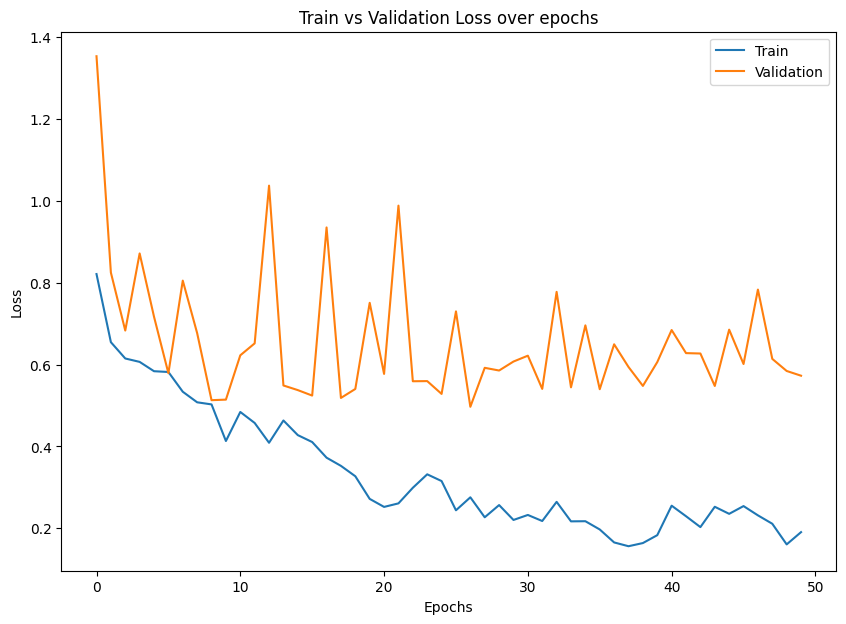

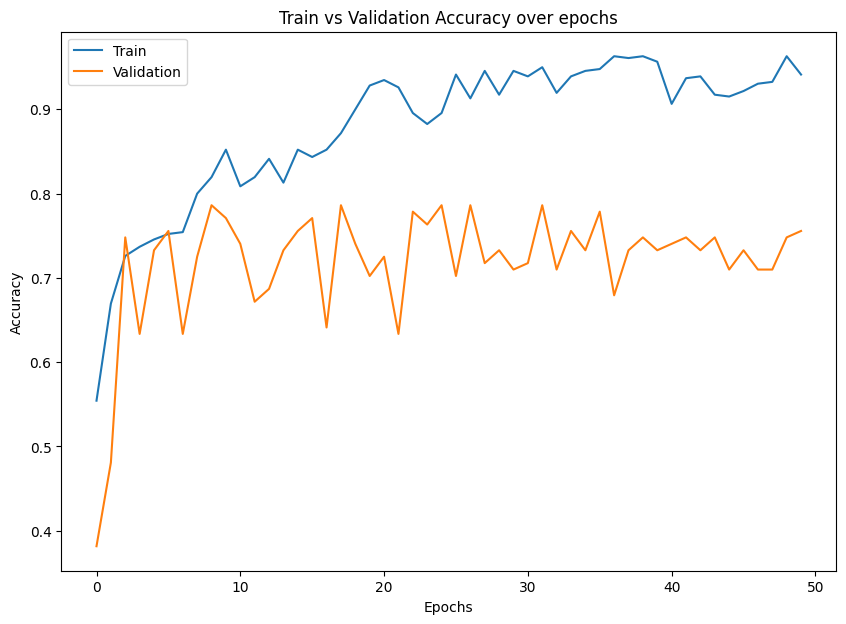

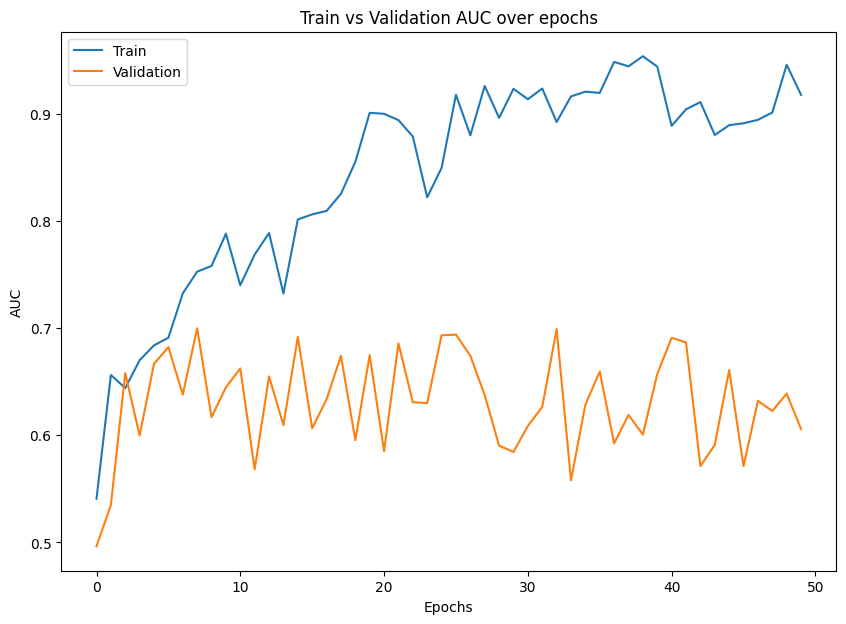

In [43]:
plot_training_results(train_losses_d, train_accs_d, train_aucs_d, val_losses_d, val_accs_d, val_aucs_d)

In [39]:
# #Load model 3 and model 4
# model_3.load_state_dict(torch.load('best_model_resnet_2.pth'))
# model_4.load_state_dict(torch.load('best_model_densenet_2.pth'))

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1330/2408048868.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


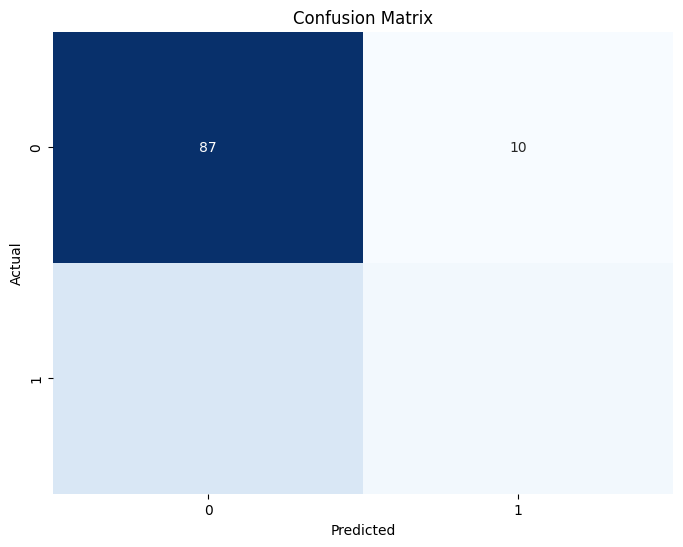

In [43]:
#Confusion matrix for model C: resnet50 with 0.3 dropout rate
plot_confusion_matrix(model_3, '../notebooks/best_model_20240813-143604.pth', val_loader)

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1330/2408048868.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


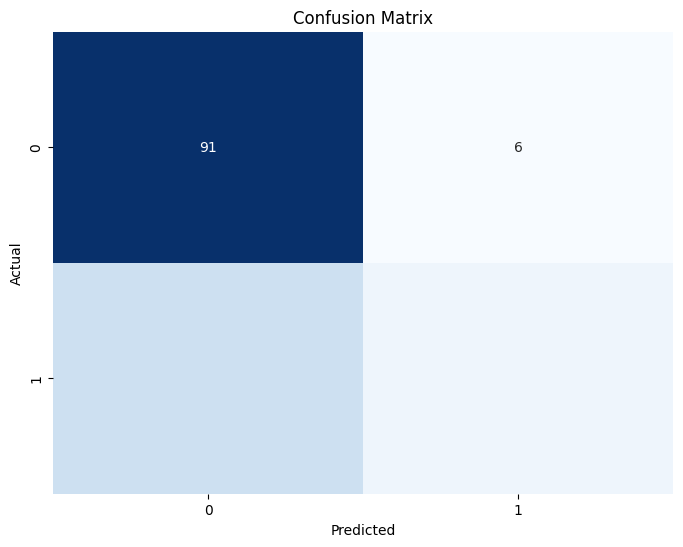

In [41]:
#Confusion matrix for model D: densenet with dropout rate of 0.3
plot_confusion_matrix(model_4, '../notebooks/best_model_20240813-152745.pth', val_loader)

In [ ]:
# #Resampling the data to make the classes balanced
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SM
# from imblearn.over_sampling import SM


In [31]:
#Address class imbalance by weighted loss function

#Calculate the class weights
def calculate_class_weights(data_loader):
    all_labels = []
    for _, labels, _ in data_loader:
        all_labels.extend(labels.cpu().numpy())
    
    class_weights = 1.0 / np.bincount(all_labels)
    return class_weights

class_weights = calculate_class_weights(train_loader)

In [32]:
#Class weights for the loss function

class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)

#Model E: Resnet with weighted loss function and 0.3 dropout

model_e = SkinLesionModel_resnet(dropout_rate=0.3)
optimizer_5 = optim.Adam(model_e.parameters(), lr=0.001)


Resnet created with 2 classes and dropout rate of 0.3


In [58]:
#Train and evaluate the model E

train_losses_e, train_accs_e, val_losses_e, val_accs_e, train_aucs_e, val_aucs_e  = train_and_eval_s(model_e, train_loader, val_loader, criterion_weighted, optimizer_5, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0)

Epoch 1/50: 100%|██████████| 15/15 [01:44<00:00,  6.96s/it, loss=0.752]


Epoch 1/50
Train Loss: 0.7626, Train Acc: 0.4457, Train AUC: 0.5415
Val Loss: 6.8829, Val Acc: 0.3282, Val AUC: 0.4604
Model with best validation accuracy saved at epoch 0 with 0.3282 accuracy!


Epoch 2/50: 100%|██████████| 15/15 [01:42<00:00,  6.85s/it, loss=0.631]


Epoch 2/50
Train Loss: 0.7084, Train Acc: 0.4652, Train AUC: 0.5574
Val Loss: 1.1061, Val Acc: 0.7099, Val AUC: 0.5940
Model with best validation accuracy saved at epoch 1 with 0.7099 accuracy!


Epoch 3/50: 100%|██████████| 15/15 [01:44<00:00,  6.96s/it, loss=0.696]


Epoch 3/50
Train Loss: 0.7440, Train Acc: 0.6565, Train AUC: 0.5358
Val Loss: 1.2744, Val Acc: 0.4580, Val AUC: 0.5863


Epoch 4/50: 100%|██████████| 15/15 [01:44<00:00,  6.97s/it, loss=0.738]


Epoch 4/50
Train Loss: 0.6809, Train Acc: 0.5543, Train AUC: 0.5701
Val Loss: 0.6968, Val Acc: 0.3664, Val AUC: 0.5244


Epoch 5/50: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it, loss=0.505]


Epoch 5/50
Train Loss: 0.6735, Train Acc: 0.5500, Train AUC: 0.6017
Val Loss: 0.6926, Val Acc: 0.7328, Val AUC: 0.6190
Model with best validation accuracy saved at epoch 4 with 0.7328 accuracy!


Epoch 6/50: 100%|██████████| 15/15 [01:44<00:00,  6.98s/it, loss=0.644]


Epoch 6/50
Train Loss: 0.6731, Train Acc: 0.5630, Train AUC: 0.5866
Val Loss: 0.6741, Val Acc: 0.6794, Val AUC: 0.6498


Epoch 7/50: 100%|██████████| 15/15 [01:45<00:00,  7.05s/it, loss=0.965]


Epoch 7/50
Train Loss: 0.6665, Train Acc: 0.6696, Train AUC: 0.6111
Val Loss: 0.7716, Val Acc: 0.5344, Val AUC: 0.6092


Epoch 8/50: 100%|██████████| 15/15 [01:44<00:00,  6.97s/it, loss=0.511]


Epoch 8/50
Train Loss: 0.6387, Train Acc: 0.6739, Train AUC: 0.6592
Val Loss: 0.6690, Val Acc: 0.6412, Val AUC: 0.6431


Epoch 9/50: 100%|██████████| 15/15 [01:45<00:00,  7.02s/it, loss=0.577]


Epoch 9/50
Train Loss: 0.6208, Train Acc: 0.6891, Train AUC: 0.6562
Val Loss: 0.6637, Val Acc: 0.6260, Val AUC: 0.6424


Epoch 10/50: 100%|██████████| 15/15 [01:49<00:00,  7.28s/it, loss=0.68] 


Epoch 10/50
Train Loss: 0.5997, Train Acc: 0.6957, Train AUC: 0.6925
Val Loss: 0.6405, Val Acc: 0.7328, Val AUC: 0.6763


Epoch 11/50: 100%|██████████| 15/15 [01:48<00:00,  7.25s/it, loss=0.429]


Epoch 11/50
Train Loss: 0.5962, Train Acc: 0.7217, Train AUC: 0.6624
Val Loss: 0.6819, Val Acc: 0.6794, Val AUC: 0.6689


Epoch 12/50: 100%|██████████| 15/15 [01:48<00:00,  7.25s/it, loss=0.633]


Epoch 12/50
Train Loss: 0.6207, Train Acc: 0.7065, Train AUC: 0.6733
Val Loss: 1.5330, Val Acc: 0.5725, Val AUC: 0.6349


Epoch 13/50: 100%|██████████| 15/15 [01:48<00:00,  7.24s/it, loss=0.468]


Epoch 13/50
Train Loss: 0.6024, Train Acc: 0.7304, Train AUC: 0.6656
Val Loss: 1.3000, Val Acc: 0.6412, Val AUC: 0.6622


Epoch 14/50: 100%|██████████| 15/15 [01:48<00:00,  7.25s/it, loss=0.729]


Epoch 14/50
Train Loss: 0.6225, Train Acc: 0.6587, Train AUC: 0.6728
Val Loss: 0.6406, Val Acc: 0.7252, Val AUC: 0.6712


Epoch 15/50: 100%|██████████| 15/15 [01:48<00:00,  7.25s/it, loss=0.563]


Epoch 15/50
Train Loss: 0.5888, Train Acc: 0.7283, Train AUC: 0.6987
Val Loss: 0.6433, Val Acc: 0.6794, Val AUC: 0.6116


Epoch 16/50: 100%|██████████| 15/15 [01:48<00:00,  7.26s/it, loss=0.508]


Epoch 16/50
Train Loss: 0.6272, Train Acc: 0.7109, Train AUC: 0.6710
Val Loss: 1.1686, Val Acc: 0.7405, Val AUC: 0.6815
Model with best validation accuracy saved at epoch 15 with 0.7405 accuracy!


Epoch 17/50: 100%|██████████| 15/15 [01:49<00:00,  7.31s/it, loss=0.62] 


Epoch 17/50
Train Loss: 0.6623, Train Acc: 0.7174, Train AUC: 0.6834
Val Loss: 0.7617, Val Acc: 0.5496, Val AUC: 0.6195


Epoch 18/50: 100%|██████████| 15/15 [01:49<00:00,  7.31s/it, loss=0.685]


Epoch 18/50
Train Loss: 0.6576, Train Acc: 0.6848, Train AUC: 0.6612
Val Loss: 0.9107, Val Acc: 0.5420, Val AUC: 0.5761


Epoch 19/50: 100%|██████████| 15/15 [01:48<00:00,  7.26s/it, loss=0.822]


Epoch 19/50
Train Loss: 0.6198, Train Acc: 0.6978, Train AUC: 0.6754
Val Loss: 1.0942, Val Acc: 0.7710, Val AUC: 0.6448
Model with best validation accuracy saved at epoch 18 with 0.7710 accuracy!


Epoch 20/50: 100%|██████████| 15/15 [01:48<00:00,  7.22s/it, loss=0.93] 


Epoch 20/50
Train Loss: 0.6173, Train Acc: 0.7087, Train AUC: 0.7040
Val Loss: 0.7898, Val Acc: 0.4504, Val AUC: 0.5429


Epoch 21/50: 100%|██████████| 15/15 [01:48<00:00,  7.26s/it, loss=1.21] 


Epoch 21/50
Train Loss: 0.6041, Train Acc: 0.6870, Train AUC: 0.6919
Val Loss: 0.8510, Val Acc: 0.7634, Val AUC: 0.6301


Epoch 22/50: 100%|██████████| 15/15 [01:49<00:00,  7.33s/it, loss=0.576]


Epoch 22/50
Train Loss: 0.5680, Train Acc: 0.7630, Train AUC: 0.7223
Val Loss: 0.6591, Val Acc: 0.5725, Val AUC: 0.5776


Epoch 23/50: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it, loss=0.774]


Epoch 23/50
Train Loss: 0.5743, Train Acc: 0.7174, Train AUC: 0.6940
Val Loss: 0.7577, Val Acc: 0.6641, Val AUC: 0.6681


Epoch 24/50: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it, loss=0.344]


Epoch 24/50
Train Loss: 0.5785, Train Acc: 0.6913, Train AUC: 0.6949
Val Loss: 0.7155, Val Acc: 0.7557, Val AUC: 0.6440


Epoch 25/50: 100%|██████████| 15/15 [01:48<00:00,  7.26s/it, loss=0.862]


Epoch 25/50
Train Loss: 0.5598, Train Acc: 0.7739, Train AUC: 0.7217
Val Loss: 0.7899, Val Acc: 0.6183, Val AUC: 0.5990


Epoch 26/50: 100%|██████████| 15/15 [01:49<00:00,  7.30s/it, loss=0.538]


Epoch 26/50
Train Loss: 0.5927, Train Acc: 0.6935, Train AUC: 0.7150
Val Loss: 0.6680, Val Acc: 0.7405, Val AUC: 0.6528


Epoch 27/50: 100%|██████████| 15/15 [01:50<00:00,  7.34s/it, loss=0.393]


Epoch 27/50
Train Loss: 0.5665, Train Acc: 0.7674, Train AUC: 0.7199
Val Loss: 0.6274, Val Acc: 0.6641, Val AUC: 0.6395


Epoch 28/50: 100%|██████████| 15/15 [01:49<00:00,  7.30s/it, loss=0.688]


Epoch 28/50
Train Loss: 0.5393, Train Acc: 0.7239, Train AUC: 0.7330
Val Loss: 0.8270, Val Acc: 0.6565, Val AUC: 0.6343


Epoch 29/50: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it, loss=0.947]


Epoch 29/50
Train Loss: 0.5953, Train Acc: 0.7413, Train AUC: 0.6916
Val Loss: 0.7202, Val Acc: 0.5802, Val AUC: 0.6019


Epoch 30/50: 100%|██████████| 15/15 [01:49<00:00,  7.31s/it, loss=0.543]


Epoch 30/50
Train Loss: 0.4987, Train Acc: 0.7891, Train AUC: 0.7639
Val Loss: 0.7687, Val Acc: 0.7099, Val AUC: 0.6322


Epoch 31/50: 100%|██████████| 15/15 [01:49<00:00,  7.27s/it, loss=0.669]


Epoch 31/50
Train Loss: 0.5669, Train Acc: 0.7391, Train AUC: 0.7061
Val Loss: 0.8053, Val Acc: 0.5725, Val AUC: 0.6349


Epoch 32/50: 100%|██████████| 15/15 [01:49<00:00,  7.29s/it, loss=0.262]


Epoch 32/50
Train Loss: 0.5031, Train Acc: 0.7370, Train AUC: 0.7418
Val Loss: 0.6991, Val Acc: 0.5954, Val AUC: 0.5931


Epoch 33/50: 100%|██████████| 15/15 [01:49<00:00,  7.31s/it, loss=1.14] 


Epoch 33/50
Train Loss: 0.4978, Train Acc: 0.8000, Train AUC: 0.7740
Val Loss: 0.7030, Val Acc: 0.6565, Val AUC: 0.6057


Epoch 34/50: 100%|██████████| 15/15 [01:49<00:00,  7.31s/it, loss=0.51] 


Epoch 34/50
Train Loss: 0.4883, Train Acc: 0.7739, Train AUC: 0.7642
Val Loss: 0.7338, Val Acc: 0.7634, Val AUC: 0.6683


Epoch 35/50: 100%|██████████| 15/15 [01:50<00:00,  7.38s/it, loss=0.573]


Epoch 35/50
Train Loss: 0.5153, Train Acc: 0.7957, Train AUC: 0.7577
Val Loss: 1.4314, Val Acc: 0.7252, Val AUC: 0.6330


Epoch 36/50: 100%|██████████| 15/15 [01:50<00:00,  7.33s/it, loss=0.678]


Epoch 36/50
Train Loss: 0.5412, Train Acc: 0.7522, Train AUC: 0.7362
Val Loss: 0.6366, Val Acc: 0.6947, Val AUC: 0.6410


Epoch 37/50: 100%|██████████| 15/15 [01:49<00:00,  7.32s/it, loss=0.543]


Epoch 37/50
Train Loss: 0.5001, Train Acc: 0.7717, Train AUC: 0.7681
Val Loss: 0.7610, Val Acc: 0.7634, Val AUC: 0.6683


Epoch 38/50: 100%|██████████| 15/15 [01:50<00:00,  7.38s/it, loss=0.303]


Epoch 38/50
Train Loss: 0.4766, Train Acc: 0.8000, Train AUC: 0.7766
Val Loss: 0.6898, Val Acc: 0.7099, Val AUC: 0.6609


Epoch 39/50: 100%|██████████| 15/15 [01:48<00:00,  7.26s/it, loss=0.393]


Epoch 39/50
Train Loss: 0.4781, Train Acc: 0.7609, Train AUC: 0.7634
Val Loss: 0.7837, Val Acc: 0.6565, Val AUC: 0.6439


Epoch 40/50: 100%|██████████| 15/15 [01:46<00:00,  7.10s/it, loss=0.506]


Epoch 40/50
Train Loss: 0.4689, Train Acc: 0.7848, Train AUC: 0.7743
Val Loss: 0.7233, Val Acc: 0.6489, Val AUC: 0.6292


Epoch 41/50: 100%|██████████| 15/15 [01:48<00:00,  7.22s/it, loss=0.462]


Epoch 41/50
Train Loss: 0.4934, Train Acc: 0.7674, Train AUC: 0.7571
Val Loss: 0.6866, Val Acc: 0.6794, Val AUC: 0.6307


Epoch 42/50: 100%|██████████| 15/15 [01:47<00:00,  7.16s/it, loss=0.299]


Epoch 42/50
Train Loss: 0.4608, Train Acc: 0.7696, Train AUC: 0.7693
Val Loss: 0.8813, Val Acc: 0.6260, Val AUC: 0.6233


Epoch 43/50: 100%|██████████| 15/15 [01:48<00:00,  7.21s/it, loss=0.603]


Epoch 43/50
Train Loss: 0.4760, Train Acc: 0.7609, Train AUC: 0.7554
Val Loss: 0.6898, Val Acc: 0.6794, Val AUC: 0.6498


Epoch 44/50: 100%|██████████| 15/15 [01:47<00:00,  7.18s/it, loss=0.702]


Epoch 44/50
Train Loss: 0.4212, Train Acc: 0.8000, Train AUC: 0.7872
Val Loss: 0.7465, Val Acc: 0.7176, Val AUC: 0.6183


Epoch 45/50: 100%|██████████| 15/15 [01:48<00:00,  7.23s/it, loss=0.291]


Epoch 45/50
Train Loss: 0.4745, Train Acc: 0.7826, Train AUC: 0.7515
Val Loss: 0.7535, Val Acc: 0.6641, Val AUC: 0.6395


Epoch 46/50: 100%|██████████| 15/15 [01:48<00:00,  7.21s/it, loss=0.23] 


Epoch 46/50
Train Loss: 0.4450, Train Acc: 0.7783, Train AUC: 0.7805
Val Loss: 1.2370, Val Acc: 0.6336, Val AUC: 0.6189


Epoch 47/50: 100%|██████████| 15/15 [01:47<00:00,  7.14s/it, loss=0.927]


Epoch 47/50
Train Loss: 0.4500, Train Acc: 0.8174, Train AUC: 0.7831
Val Loss: 0.9570, Val Acc: 0.6489, Val AUC: 0.6674


Epoch 48/50: 100%|██████████| 15/15 [01:47<00:00,  7.19s/it, loss=0.461]


Epoch 48/50
Train Loss: 0.4658, Train Acc: 0.7652, Train AUC: 0.7743
Val Loss: 0.7088, Val Acc: 0.6412, Val AUC: 0.6145


Epoch 49/50: 100%|██████████| 15/15 [01:51<00:00,  7.45s/it, loss=0.57] 


Epoch 49/50
Train Loss: 0.4204, Train Acc: 0.8109, Train AUC: 0.8238
Val Loss: 0.8597, Val Acc: 0.7023, Val AUC: 0.6748


Epoch 50/50: 100%|██████████| 15/15 [01:50<00:00,  7.37s/it, loss=0.438]


Epoch 50/50
Train Loss: 0.3892, Train Acc: 0.8304, Train AUC: 0.8238
Val Loss: 1.0171, Val Acc: 0.6718, Val AUC: 0.5491


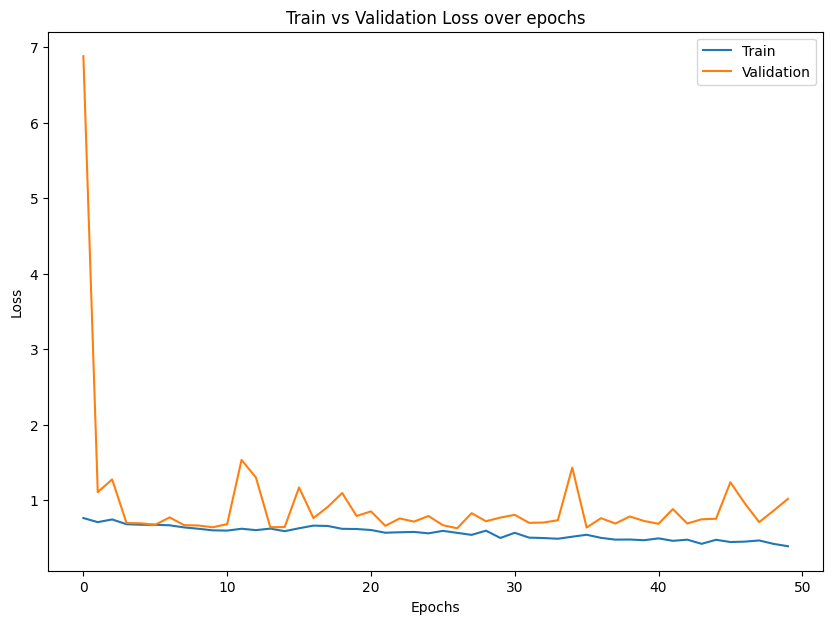

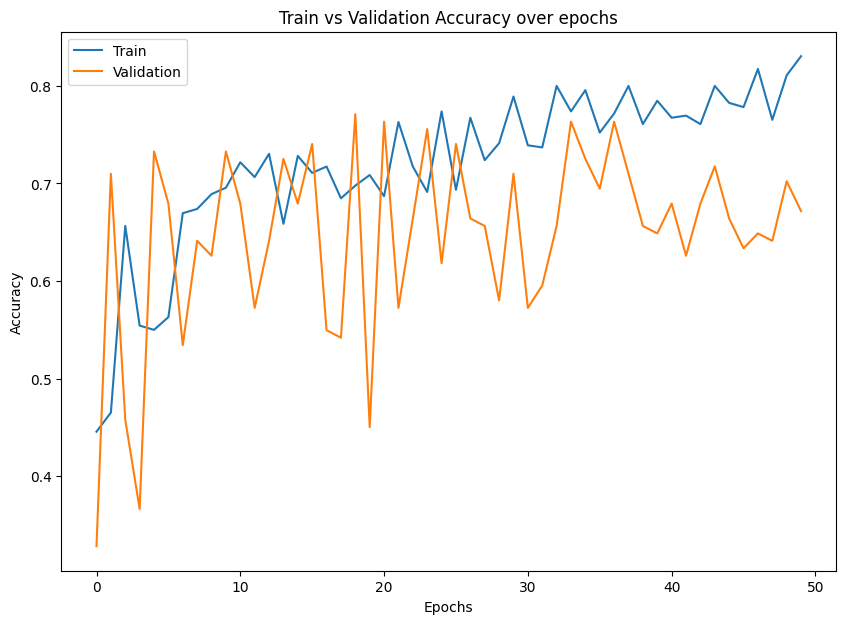

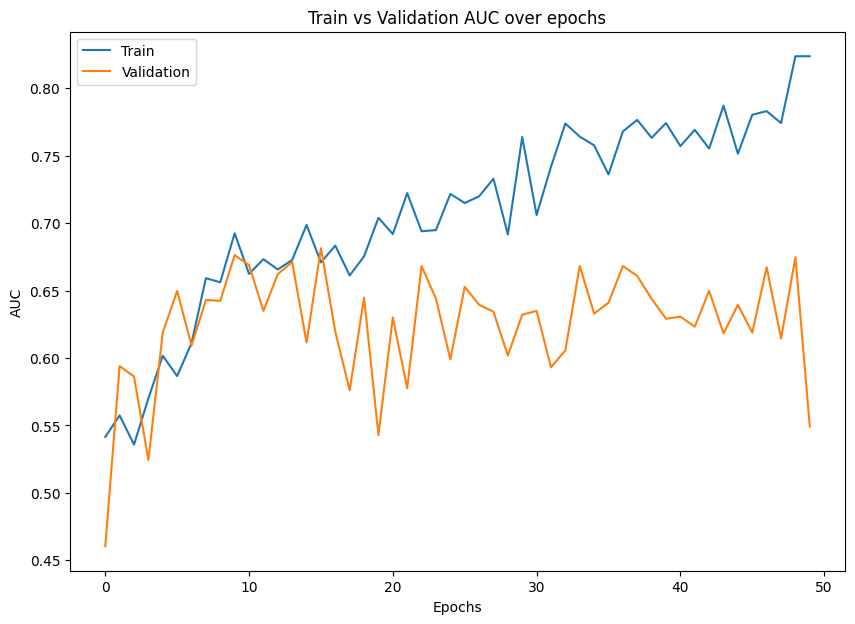

In [60]:
#Plot 
plot_training_results(train_losses_e, train_accs_e, train_aucs_e, val_losses_e, val_accs_e, val_aucs_e)


In [33]:
model_f = CustomDenseNet121(dropout_rate=0.3)
optimizer_6 = optim.Adam(model_f.parameters(), lr=0.001)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)


DenseNet121 created with 2 classes and dropout rate of 0.3
Model has 7249796 trainable params.


In [59]:
#Train and evaluate the model F

train_losses_f, train_accs_f, val_losses_f, val_accs_f, train_aucs_f, val_aucs_f  = train_and_eval_s(model_f, train_loader, val_loader, criterion_weighted, optimizer_6, scheduler=None, num_epochs=50, lr_min=1e-6, early_stopping=True, save_highest=True, start_epoch=0)

Epoch 1/50: 100%|██████████| 15/15 [02:02<00:00,  8.15s/it, loss=0.689]


Epoch 1/50
Train Loss: 0.7482, Train Acc: 0.5783, Train AUC: 0.5730
Val Loss: 1.0620, Val Acc: 0.2901, Val AUC: 0.5111
Model with best validation accuracy saved at epoch 0 with 0.2901 accuracy!


Epoch 2/50: 100%|██████████| 15/15 [01:58<00:00,  7.93s/it, loss=0.815]


Epoch 2/50
Train Loss: 0.6515, Train Acc: 0.6522, Train AUC: 0.6604
Val Loss: 0.8266, Val Acc: 0.4733, Val AUC: 0.5775
Model with best validation accuracy saved at epoch 1 with 0.4733 accuracy!


Epoch 3/50: 100%|██████████| 15/15 [02:00<00:00,  8.03s/it, loss=0.484]


Epoch 3/50
Train Loss: 0.6116, Train Acc: 0.6848, Train AUC: 0.6798
Val Loss: 0.6614, Val Acc: 0.7023, Val AUC: 0.6175
Model with best validation accuracy saved at epoch 2 with 0.7023 accuracy!


Epoch 4/50: 100%|██████████| 15/15 [02:00<00:00,  8.02s/it, loss=0.476]


Epoch 4/50
Train Loss: 0.5587, Train Acc: 0.7435, Train AUC: 0.7595
Val Loss: 0.7198, Val Acc: 0.6183, Val AUC: 0.5990


Epoch 5/50: 100%|██████████| 15/15 [02:01<00:00,  8.08s/it, loss=0.937]


Epoch 5/50
Train Loss: 0.5223, Train Acc: 0.7283, Train AUC: 0.7731
Val Loss: 0.6788, Val Acc: 0.6565, Val AUC: 0.6630


Epoch 6/50: 100%|██████████| 15/15 [02:01<00:00,  8.11s/it, loss=0.576]


Epoch 6/50
Train Loss: 0.5558, Train Acc: 0.7522, Train AUC: 0.7415
Val Loss: 0.6376, Val Acc: 0.7557, Val AUC: 0.6536
Model with best validation accuracy saved at epoch 5 with 0.7557 accuracy!


Epoch 7/50: 100%|██████████| 15/15 [02:02<00:00,  8.15s/it, loss=0.542]


Epoch 7/50
Train Loss: 0.5523, Train Acc: 0.7174, Train AUC: 0.7259
Val Loss: 0.6707, Val Acc: 0.6031, Val AUC: 0.6173


Epoch 8/50: 100%|██████████| 15/15 [02:01<00:00,  8.12s/it, loss=0.941]


Epoch 8/50
Train Loss: 0.5124, Train Acc: 0.7196, Train AUC: 0.7486
Val Loss: 0.6212, Val Acc: 0.6870, Val AUC: 0.7218


Epoch 9/50: 100%|██████████| 15/15 [02:03<00:00,  8.27s/it, loss=0.387]


Epoch 9/50
Train Loss: 0.4617, Train Acc: 0.7609, Train AUC: 0.8032
Val Loss: 0.6442, Val Acc: 0.6031, Val AUC: 0.6555


Epoch 10/50: 100%|██████████| 15/15 [02:01<00:00,  8.09s/it, loss=0.84] 


Epoch 10/50
Train Loss: 0.4110, Train Acc: 0.8000, Train AUC: 0.8244
Val Loss: 0.6929, Val Acc: 0.6183, Val AUC: 0.6277


Epoch 11/50: 100%|██████████| 15/15 [02:04<00:00,  8.27s/it, loss=0.689]


Epoch 11/50
Train Loss: 0.4610, Train Acc: 0.7696, Train AUC: 0.7932
Val Loss: 0.7264, Val Acc: 0.6718, Val AUC: 0.5873


Epoch 12/50: 100%|██████████| 15/15 [02:04<00:00,  8.30s/it, loss=0.668]


Epoch 12/50
Train Loss: 0.4359, Train Acc: 0.8000, Train AUC: 0.8218
Val Loss: 0.8225, Val Acc: 0.6336, Val AUC: 0.6093


Epoch 13/50: 100%|██████████| 15/15 [02:02<00:00,  8.16s/it, loss=0.457]


Epoch 13/50
Train Loss: 0.3782, Train Acc: 0.8109, Train AUC: 0.8398
Val Loss: 0.7396, Val Acc: 0.6183, Val AUC: 0.5894


Epoch 14/50: 100%|██████████| 15/15 [02:03<00:00,  8.24s/it, loss=0.357]


Epoch 14/50
Train Loss: 0.3488, Train Acc: 0.8587, Train AUC: 0.8536
Val Loss: 0.6524, Val Acc: 0.7176, Val AUC: 0.6660


Epoch 15/50: 100%|██████████| 15/15 [02:02<00:00,  8.17s/it, loss=0.52] 


Epoch 15/50
Train Loss: 0.3174, Train Acc: 0.8826, Train AUC: 0.8832
Val Loss: 0.6529, Val Acc: 0.6794, Val AUC: 0.6880


Epoch 16/50: 100%|██████████| 15/15 [02:03<00:00,  8.26s/it, loss=0.299]


Epoch 16/50
Train Loss: 0.2841, Train Acc: 0.8891, Train AUC: 0.9088
Val Loss: 0.9942, Val Acc: 0.5573, Val AUC: 0.6437


Epoch 17/50: 100%|██████████| 15/15 [02:00<00:00,  8.01s/it, loss=0.248]


Epoch 17/50
Train Loss: 0.3066, Train Acc: 0.8848, Train AUC: 0.8979
Val Loss: 0.7864, Val Acc: 0.7023, Val AUC: 0.5697


Epoch 18/50: 100%|██████████| 15/15 [02:00<00:00,  8.01s/it, loss=0.318]


Epoch 18/50
Train Loss: 0.2503, Train Acc: 0.9391, Train AUC: 0.9374
Val Loss: 0.7445, Val Acc: 0.7023, Val AUC: 0.6844


Epoch 19/50: 100%|██████████| 15/15 [02:01<00:00,  8.10s/it, loss=0.306]


Epoch 19/50
Train Loss: 0.2502, Train Acc: 0.9370, Train AUC: 0.9360
Val Loss: 0.6071, Val Acc: 0.7481, Val AUC: 0.7535


Epoch 20/50: 100%|██████████| 15/15 [02:00<00:00,  8.01s/it, loss=0.256]


Epoch 20/50
Train Loss: 0.3239, Train Acc: 0.8674, Train AUC: 0.8781
Val Loss: 0.9236, Val Acc: 0.5725, Val AUC: 0.6445


Epoch 21/50: 100%|██████████| 15/15 [02:00<00:00,  8.03s/it, loss=0.205]


Epoch 21/50
Train Loss: 0.2917, Train Acc: 0.8891, Train AUC: 0.8902
Val Loss: 0.7545, Val Acc: 0.7328, Val AUC: 0.6381


Epoch 22/50: 100%|██████████| 15/15 [02:00<00:00,  8.05s/it, loss=0.305]


Epoch 22/50
Train Loss: 0.2839, Train Acc: 0.9043, Train AUC: 0.9112
Val Loss: 0.6160, Val Acc: 0.7710, Val AUC: 0.7212
Model with best validation accuracy saved at epoch 21 with 0.7710 accuracy!


Epoch 23/50: 100%|██████████| 15/15 [02:00<00:00,  8.06s/it, loss=0.262]


Epoch 23/50
Train Loss: 0.2080, Train Acc: 0.9174, Train AUC: 0.9333
Val Loss: 0.6980, Val Acc: 0.7099, Val AUC: 0.6704


Epoch 24/50: 100%|██████████| 15/15 [02:01<00:00,  8.07s/it, loss=0.106]


Epoch 24/50
Train Loss: 0.2562, Train Acc: 0.9043, Train AUC: 0.9006
Val Loss: 0.7393, Val Acc: 0.6412, Val AUC: 0.6622


Epoch 25/50: 100%|██████████| 15/15 [02:01<00:00,  8.08s/it, loss=0.18] 


Epoch 25/50
Train Loss: 0.2506, Train Acc: 0.9087, Train AUC: 0.9088
Val Loss: 0.7948, Val Acc: 0.6718, Val AUC: 0.6255


Epoch 26/50: 100%|██████████| 15/15 [02:01<00:00,  8.12s/it, loss=0.416]


Epoch 26/50
Train Loss: 0.2114, Train Acc: 0.9370, Train AUC: 0.9333
Val Loss: 0.7030, Val Acc: 0.6947, Val AUC: 0.6505


Epoch 27/50: 100%|██████████| 15/15 [01:59<00:00,  7.96s/it, loss=0.198]


Epoch 27/50
Train Loss: 0.1900, Train Acc: 0.9500, Train AUC: 0.9581
Val Loss: 0.8425, Val Acc: 0.5878, Val AUC: 0.6548


Epoch 28/50: 100%|██████████| 15/15 [02:01<00:00,  8.07s/it, loss=0.301]


Epoch 28/50
Train Loss: 0.2574, Train Acc: 0.9087, Train AUC: 0.9274
Val Loss: 0.6797, Val Acc: 0.7328, Val AUC: 0.7050


Epoch 29/50: 100%|██████████| 15/15 [02:00<00:00,  8.02s/it, loss=0.128]


Epoch 29/50
Train Loss: 0.1728, Train Acc: 0.9630, Train AUC: 0.9643
Val Loss: 0.8154, Val Acc: 0.6641, Val AUC: 0.6299


Epoch 30/50: 100%|██████████| 15/15 [02:01<00:00,  8.10s/it, loss=0.229]


Epoch 30/50
Train Loss: 0.1679, Train Acc: 0.9587, Train AUC: 0.9667
Val Loss: 0.6897, Val Acc: 0.7405, Val AUC: 0.6815


Epoch 31/50: 100%|██████████| 15/15 [02:02<00:00,  8.15s/it, loss=0.105]


Epoch 31/50
Train Loss: 0.1472, Train Acc: 0.9804, Train AUC: 0.9734
Val Loss: 0.6667, Val Acc: 0.6794, Val AUC: 0.6784


Epoch 32/50: 100%|██████████| 15/15 [02:01<00:00,  8.07s/it, loss=0.158]


Epoch 32/50
Train Loss: 0.1463, Train Acc: 0.9739, Train AUC: 0.9796
Val Loss: 0.7044, Val Acc: 0.7176, Val AUC: 0.6851


Epoch 33/50: 100%|██████████| 15/15 [02:01<00:00,  8.08s/it, loss=0.197]


Epoch 33/50
Train Loss: 0.2095, Train Acc: 0.9413, Train AUC: 0.9389
Val Loss: 0.6981, Val Acc: 0.6870, Val AUC: 0.6740


Epoch 34/50: 100%|██████████| 15/15 [02:02<00:00,  8.14s/it, loss=0.108]


Epoch 34/50
Train Loss: 0.2035, Train Acc: 0.9370, Train AUC: 0.9413
Val Loss: 0.8051, Val Acc: 0.7328, Val AUC: 0.5904


Epoch 35/50: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it, loss=0.0923]


Epoch 35/50
Train Loss: 0.2330, Train Acc: 0.9217, Train AUC: 0.9230
Val Loss: 0.8783, Val Acc: 0.7557, Val AUC: 0.5867


Epoch 36/50: 100%|██████████| 15/15 [02:01<00:00,  8.11s/it, loss=0.965]


Epoch 36/50
Train Loss: 0.2255, Train Acc: 0.9413, Train AUC: 0.9336
Val Loss: 0.7774, Val Acc: 0.6947, Val AUC: 0.7174


Epoch 37/50: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it, loss=0.0983]


Epoch 37/50
Train Loss: 0.1908, Train Acc: 0.9413, Train AUC: 0.9336
Val Loss: 0.5938, Val Acc: 0.7557, Val AUC: 0.7300


Epoch 38/50: 100%|██████████| 15/15 [02:01<00:00,  8.08s/it, loss=0.199]


Epoch 38/50
Train Loss: 0.1806, Train Acc: 0.9391, Train AUC: 0.9481
Val Loss: 0.6225, Val Acc: 0.7099, Val AUC: 0.6895


Epoch 39/50: 100%|██████████| 15/15 [02:01<00:00,  8.11s/it, loss=0.158] 


Epoch 39/50
Train Loss: 0.1563, Train Acc: 0.9565, Train AUC: 0.9546
Val Loss: 0.6493, Val Acc: 0.7786, Val AUC: 0.7263
Model with best validation accuracy saved at epoch 38 with 0.7786 accuracy!


Epoch 40/50: 100%|██████████| 15/15 [02:00<00:00,  8.02s/it, loss=0.112] 


Epoch 40/50
Train Loss: 0.1380, Train Acc: 0.9630, Train AUC: 0.9696
Val Loss: 0.6612, Val Acc: 0.7252, Val AUC: 0.6998


Epoch 41/50: 100%|██████████| 15/15 [02:01<00:00,  8.11s/it, loss=0.101] 


Epoch 41/50
Train Loss: 0.1422, Train Acc: 0.9696, Train AUC: 0.9661
Val Loss: 0.6632, Val Acc: 0.7710, Val AUC: 0.7116


Epoch 42/50: 100%|██████████| 15/15 [02:01<00:00,  8.12s/it, loss=0.247]


Epoch 42/50
Train Loss: 0.1689, Train Acc: 0.9500, Train AUC: 0.9448
Val Loss: 0.8280, Val Acc: 0.7023, Val AUC: 0.6366


Epoch 43/50: 100%|██████████| 15/15 [02:01<00:00,  8.07s/it, loss=0.31] 


Epoch 43/50
Train Loss: 0.2332, Train Acc: 0.8891, Train AUC: 0.9115
Val Loss: 0.7725, Val Acc: 0.7099, Val AUC: 0.6800


Epoch 44/50: 100%|██████████| 15/15 [02:00<00:00,  8.06s/it, loss=0.996]


Epoch 44/50
Train Loss: 0.2576, Train Acc: 0.9043, Train AUC: 0.9006
Val Loss: 0.7354, Val Acc: 0.6947, Val AUC: 0.6696


Epoch 45/50: 100%|██████████| 15/15 [02:00<00:00,  8.06s/it, loss=0.14] 


Epoch 45/50
Train Loss: 0.1808, Train Acc: 0.9543, Train AUC: 0.9584
Val Loss: 0.8976, Val Acc: 0.5115, Val AUC: 0.5459


Epoch 46/50: 100%|██████████| 15/15 [02:01<00:00,  8.08s/it, loss=0.105]


Epoch 46/50
Train Loss: 0.1833, Train Acc: 0.9457, Train AUC: 0.9472
Val Loss: 0.8273, Val Acc: 0.7176, Val AUC: 0.6565


Epoch 47/50: 100%|██████████| 15/15 [02:00<00:00,  8.07s/it, loss=0.197]


Epoch 47/50
Train Loss: 0.1581, Train Acc: 0.9565, Train AUC: 0.9546
Val Loss: 0.7616, Val Acc: 0.7786, Val AUC: 0.6690


Epoch 48/50: 100%|██████████| 15/15 [02:00<00:00,  8.00s/it, loss=0.105]


Epoch 48/50
Train Loss: 0.1785, Train Acc: 0.9391, Train AUC: 0.9428
Val Loss: 0.7966, Val Acc: 0.7863, Val AUC: 0.6933
Model with best validation accuracy saved at epoch 47 with 0.7863 accuracy!


Epoch 49/50: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it, loss=0.352]


Epoch 49/50
Train Loss: 0.2183, Train Acc: 0.9152, Train AUC: 0.9212
Val Loss: 0.7632, Val Acc: 0.6794, Val AUC: 0.6498


Epoch 50/50: 100%|██████████| 15/15 [02:01<00:00,  8.12s/it, loss=0.741]


Epoch 50/50
Train Loss: 0.1879, Train Acc: 0.9413, Train AUC: 0.9416
Val Loss: 0.7689, Val Acc: 0.7328, Val AUC: 0.6954


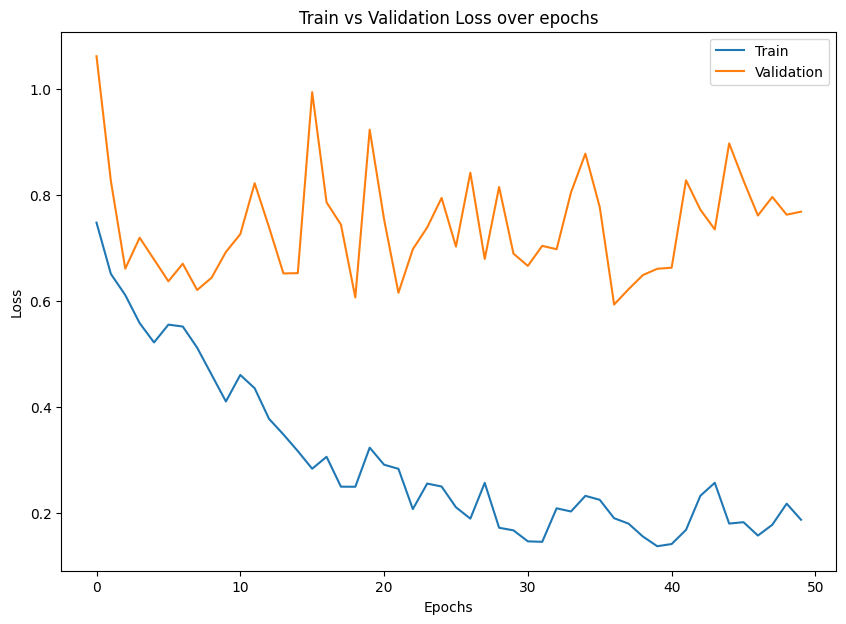

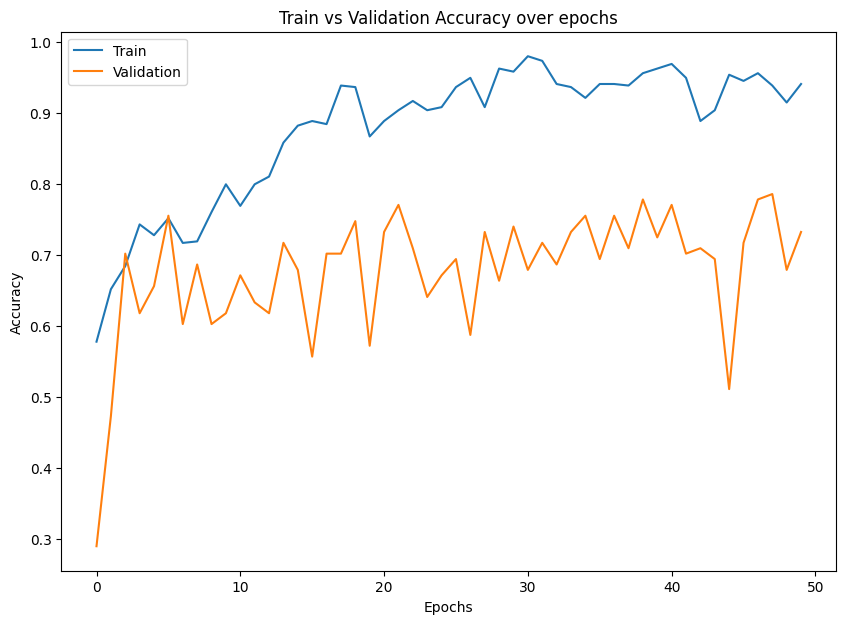

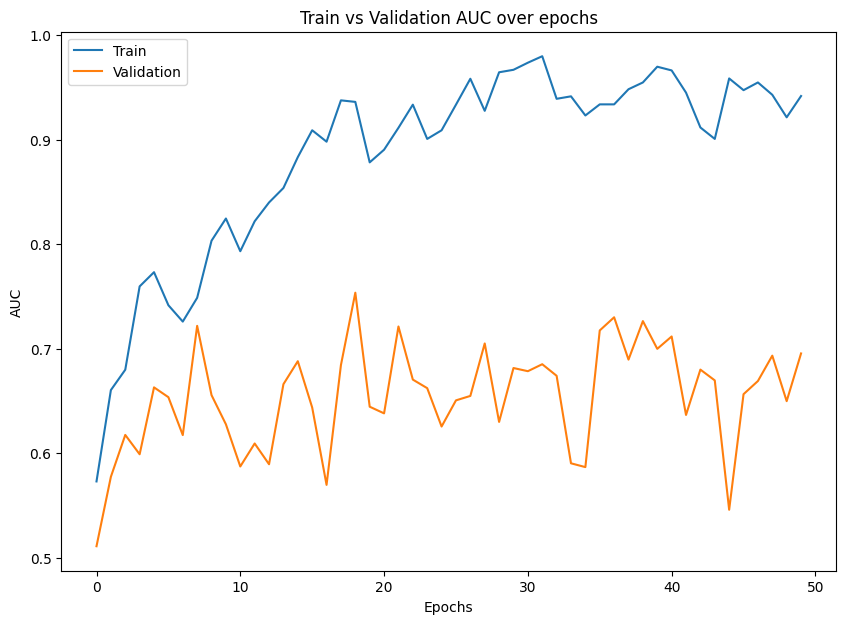

In [61]:
#Plot metrics F
plot_training_results(train_losses_f, train_accs_f, train_aucs_f, val_losses_f, val_accs_f, val_aucs_f)

In [62]:
#Save mdel E and F
torch.save(model_e.state_dict(), 'best_model_resnet_weighted.pth')
torch.save(model_f.state_dict(), 'best_model_densenet_weighted.pth')

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1330/2408048868.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


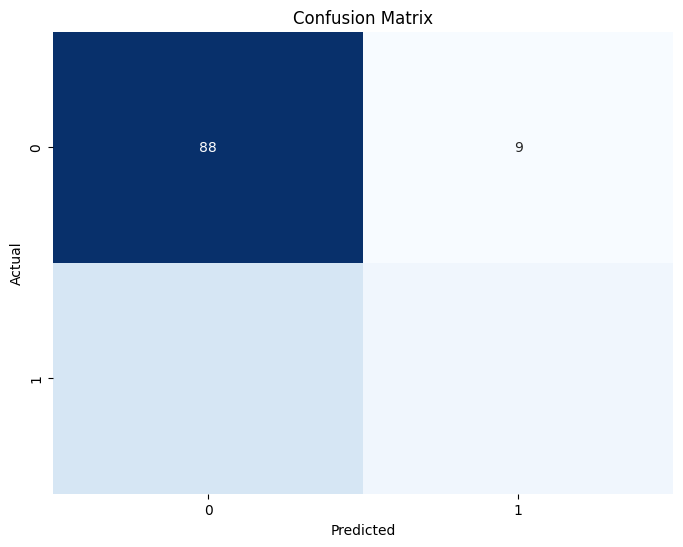

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1330/2408048868.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


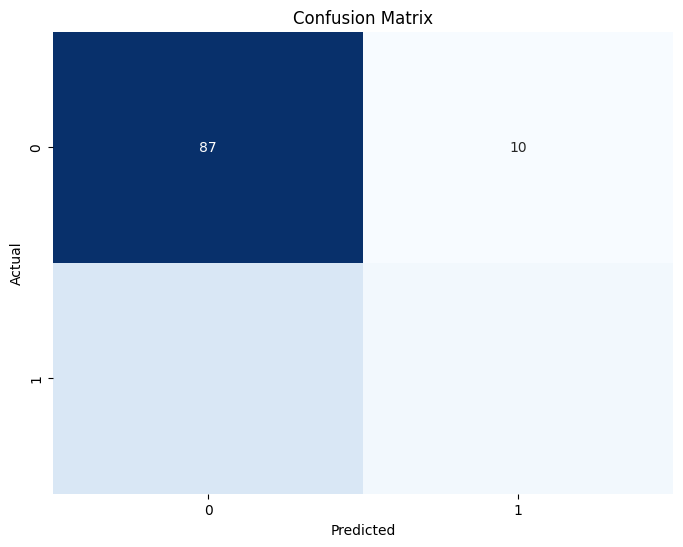

In [64]:
#Confusion matrix for model E: resnet50 with 0.3 dropout rate and weighted loss function
plot_confusion_matrix(model_e, '../notebooks/best_model_20240814-010048.pth', val_loader)
#Confusion matrix for model F: densenet with dropout rate of 0.3 and weighted loss function
plot_confusion_matrix(model_f, '../notebooks/best_model_20240814-042148.pth', val_loader) 

### Ensemble Models 

An ensemble is a machine learning concept where multiple models are trained and their predictions are combined in some way (like voting or averaging) to make a final prediction. The idea is that the ensemble as a whole is often more accurate than any individual model.

Here's a breakdown of the functions:

ensemble_predictions(models, data_loader): This function takes a list of models and a data loader. It runs each model on the data and collects the predictions and labels.

ensemble_voting(models, data_loader): This function calls ensemble_predictions to get the predictions from all models. It then averages the predictions (assuming they are probabilities) and applies a threshold of 0.5 to get a final binary prediction. This is a form of "voting" where each model gets a say and the final decision is made by averaging.

evaluate_ensemble(models, data_loader): This function calls ensemble_voting to get the final ensemble predictions and then calculates the accuracy and AUC-ROC of these predictions.

Lastly, I will load the models from their state dicts, create an ensemble from them, and evaluate the ensemble on the data from the test_loader. 

In [54]:
#Ensemble voting
def ensemble_predictions(models, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    all_labels = []
    all_preds = []

    for images, labels, _ in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = np.zeros((len(models), len(labels)))
        for i, model in enumerate(models):
            model.eval()
            model.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            preds[i] = pred.cpu().numpy()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.append(preds)

    all_preds = np.hstack(all_preds)
    return all_labels, all_preds

def ensemble_voting(models, data_loader):
    all_labels, all_preds = ensemble_predictions(models, data_loader)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Majority voting
    ensemble_preds = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=all_preds)
    return all_labels, ensemble_preds

def evaluate_ensemble(models, data_loader):
    all_labels, ensemble_preds = ensemble_voting(models, data_loader)
    acc = np.mean(all_labels == ensemble_preds)
    auc = roc_auc_score(all_labels, ensemble_preds)
    return acc, auc


In [53]:
model_aa = SkinLesionModel_resnet(dropout_rate=0.1) #Initial model A
model_bb = CustomDenseNet121(dropout_rate=0.1) #Initial model B
modelc = SkinLesionModel_resnet(dropout_rate=0.3) #Model C
modeld = CustomDenseNet121(dropout_rate=0.3) #Model D
modele = SkinLesionModel_resnet(dropout_rate=0.3) #Model E
modelf = CustomDenseNet121(dropout_rate=0.3) #Model F


/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet created with 2 classes and dropout rate of 0.1
DenseNet121 created with 2 classes and dropout rate of 0.1
Model has 7249796 trainable params.


/opt/miniconda3/envs/test1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet created with 2 classes and dropout rate of 0.3
DenseNet121 created with 2 classes and dropout rate of 0.3
Model has 7249796 trainable params.
Resnet created with 2 classes and dropout rate of 0.3
DenseNet121 created with 2 classes and dropout rate of 0.3
Model has 7249796 trainable params.


In [95]:
best_a_path = '../models/bestmodels/best_model_20240813-004135.pth'
best_b_path = '../models/bestmodels/best_model_20240813-015436.pth'
best_c_path = '../models/bestmodels/best_model_20240813-143604.pth'
best_d_path = '../models/bestmodels/best_model_20240813-152745.pth'
best_e_path = '../models/bestmodels/best_model_20240814-010048.pth'
best_f_path = '../models/bestmodels/best_model_20240814-042148.pth'

In [73]:
#USe the paths and torch load to load the models but not the model dict and the other things saved
torch.load(best_a_path).keys()
rel_keys = ['epoch', 'val_acc', 'train_accs', 'train_losses', 'val_accs', 'val_losses', 'train_aucs', 'val_aucs']

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1139/1329114141.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(best_a_path).keys()


dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'val_acc', 'train_accs', 'train_losses', 'val_accs', 'val_losses', 'train_aucs', 'val_aucs', 'lrs'])

In [74]:
# Load the model dictionary
model_dict = torch.load(best_a_path)

# Extract the relevant keys
rel_keys = ['epoch', 'val_acc', 'train_accs', 'train_losses', 'val_accs', 'val_losses', 'train_aucs', 'val_aucs']
rel_values = {key: model_dict[key] for key in rel_keys}

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1139/1905200025.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(best_a_path)


In [76]:
def load_model_info(model_path):
    # Load the model dictionary
    model_dict = torch.load(model_path)

    # Extract the relevant keys
    rel_keys = ['epoch', 'val_acc', 'train_accs', 'train_losses', 'val_accs', 'val_losses', 'train_aucs', 'val_aucs']
    rel_values = {key: model_dict[key] for key in rel_keys}

    return rel_values

# List of paths to your models
model_paths = [best_a_path, best_b_path, best_c_path, best_d_path, best_e_path, best_f_path]

# Load the information for each model
model_info_list = [load_model_info(model_path) for model_path in model_paths]

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1139/2229716267.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path)


In [85]:
#model_info_list

In [56]:
def load_models(model_classes, model_paths):
    models_loaded = []
    for model_class, model_path in zip(model_classes, model_paths):
        model = model_class  # Instantiate the model
        checkpoint = torch.load(model_path)  # Load the checkpoint
        model.load_state_dict(checkpoint['model_state_dict'])  # Load the state dictionary
        models_loaded.append(model)
    return models_loaded

In [57]:
model_classes = [model_aa, model_bb, modelc, modeld, modele, modelf]
model_paths = [best_a_path, best_b_path, best_c_path, best_d_path, best_e_path, best_f_path]

In [58]:
models_loaded = load_models(model_classes, model_paths)

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1139/169783767.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)  # Load the

In [60]:
models_s = models_loaded[:4] #Select the best 4 models: A, C, D, F
accc, aucc = evaluate_ensemble(models_s, val_loader)
print(f"Ensemble Accuracy: {accc:.4f}, Ensemble AUC: {aucc:.4f}")

Ensemble Accuracy: 0.7786, Ensemble AUC: 0.6022


In [62]:
models_all = models_loaded
accc, aucc = evaluate_ensemble(models_all, val_loader)
print(f"Ensemble Accuracy: {accc:.4f}, Ensemble AUC: {aucc:.4f}")

Ensemble Accuracy: 0.7939, Ensemble AUC: 0.6316


In [93]:
#Select the best 4 models: A, C, D, F
models_d = np.array(models_loaded)[[0, 2, 3, 5]]
accc, aucc = evaluate_ensemble(models_s, val_loader)
print(f"Ensemble Accuracy: {accc:.4f}, Ensemble AUC: {aucc:.4f}")

Ensemble Accuracy: 0.7634, Ensemble AUC: 0.5823


**Ensemble Accuracy: 0.7939**

The ensemble accuracy of 0.7939 means that 79.39% of the time, the ensemble model correctly predicted the class labels for your test set.
Accuracy is calculated as the ratio of correctly predicted observations to the total observations.

In our case, the ensemble model made correct predictions about 79% of the time, which can be considered a decent performance depending on your specific task.

**Ensemble AUC: 0.6316**

The ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) for different threshold values.
The AUC value of 0.6125 indicates the model's ability to distinguish between the positive and negative classes.

Interpreting AUC:
0.5: No discrimination (the model is guessing).

0.5 - 0.7: Poor discrimination.

0.7 - 0.8: Acceptable discrimination.

0.8 - 0.9: Excellent discrimination.

more than 0.9: Outstanding discrimination.

In this case, an AUC of 0.6316 suggests that the model is doing better than random guessing, but its ability to distinguish between classes could be improved.

In [63]:
#Calculate recall and precision
def calculate_recall_precision(labels, preds):
    recall = recall_score(labels, preds)
    precision = precision_score(labels, preds)
    return recall, precision

labels_, preds_ = ensemble_voting(models_all, val_loader)
recall_, precision_ = calculate_recall_precision(labels_, preds_)

In [65]:
recall_, precision_

(0.23529411764705882, 0.8)

The values (0.23529411764705882, 0.8) represent the recall and precision of my ensemble model, respectively.

Recall (also known as sensitivity or true positive rate) is the fraction of the total amount of relevant instances that were actually retrieved. It is calculated as TP / (TP + FN), where TP is the number of true positives and FN is the number of false negatives. In this case, my ensemble model's recall is approximately 0.2353, which means that it correctly identified about 23.53% of the relevant instances.

Precision (also known as positive predictive value) is the fraction of relevant instances among the retrieved instances. It is calculated as TP / (TP + FP), where TP is the number of true positives and FP is the number of false positives. In this case, my ensemble model's precision is 0.8, which means that about 80% of the instances that it identified as positive were actually positive.

So, in conclusion, a model with high precision but low recall returns very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

In my case, it's crucial to identify as many positive cases (cancer) as possible. A low recall, like 0.2353 in your case, means the model is missing a lot of positive cases, which is not ideal for such a critical task. In medical scenarios, a false negative (missing a real positive case) can be much more dangerous than a false positive (incorrectly identifying a negative case as positive). 

Therefore, in the future I want to adjust the model or use techniques like threshold moving, oversampling, undersampling, or SMOTE to increase the recall.




In [68]:
#change this to load the validation data and training data (acc, auc)
def metrics(model_paths):
    model_classes = [model_aa, model_bb, modelc, modeld, modele, modelf]
    models_loaded = load_models(model_classes, model_paths)
    models_s = models_loaded[:2]
    accc, aucc = evaluate_ensemble(models_s, val_loader)
    print(f"Ensemble Accuracy: {accc:.4f}, Ensemble AUC: {aucc:.4f}")

    models_all = models_loaded
    accc, aucc = evaluate_ensemble(models_all, val_loader)
    print(f"Ensemble Accuracy: {accc:.4f}, Ensemble AUC: {aucc:.4f}")

    labels_, preds_ = ensemble_voting(models_all, val_loader)
    recall_, precision_ = calculate_recall_precision(labels_, preds_)

    recall_, precision_

    return accc, aucc, recall_, precision_

In [69]:
metrics([best_a_path, best_b_path, best_c_path, best_d_path, best_e_path, best_f_path])

/var/folders/lj/q60gsp452vs5l7xmtn778jn80000gn/T/ipykernel_1139/169783767.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)  # Load the

Ensemble Accuracy: 0.7557, Ensemble AUC: 0.5581
Ensemble Accuracy: 0.8015, Ensemble AUC: 0.6463


(0.8015267175572519,
 0.6463007883565797,
 0.29411764705882354,
 0.7692307692307693)

## Model inferencing 

The inference function allows you to load an image, preprocess it, and run it through the trained model to get predictions. This process involves resizing and normalizing the image, performing a forward pass through the model, and interpreting the output to get the predicted class label and probabilities. This function can be used to perform inference on new, unseen images to classify them based on the model's learned features.

**Step-by-Step Example:**

- Define the Inference Function: The function will load an image, preprocess it, run it through the model, and output the predictions.

- Load and Preprocess the Image: Convert the image to a tensor and normalize it.

- Run Inference: Pass the preprocessed image through the model to get predictions.

- Post-process and Display Results: Interpret the model's output to get the class labels.

In [64]:
def infer(model, image_path, device='cpu'):
    """
    Perform inference on a single image using the trained model.
    
    Args:
        model: The trained PyTorch model.
        image_path (str): Path to the input image.
        device (str): Device to run the inference on ('cuda' or 'cpu').
        
    Returns:
        pred_label (int): Predicted label for the input image.
        pred_probs (torch.Tensor): Class probabilities for the input image.
    """
    # Define the image transformations
    transform = T.Compose([
        T.Resize((224, 224)),  # Resize the image to the required input size
        T.ToTensor(),        # Convert the image to a tensor
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])
    
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformations
    image = transform(image)
    
    # Add a batch dimension
    image = image.unsqueeze(0).to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # Disable gradient calculation
        # Perform the forward pass
        outputs = model(image)
        
        # Get the predicted class probabilities
        pred_probs = torch.nn.functional.softmax(outputs, dim=1)
        
        # Get the predicted label
        _, pred_label = torch.max(outputs, 1)
    
    return pred_label.item(), pred_probs.squeeze().tolist()

In [87]:
infer_f = models_loaded[5]

In [88]:
#Use the infer function to make predictions
image_path = '../data/DDI/images/000020.png'
pred_label, pred_probs = infer(infer_f, image_path)


In [89]:
print(f'Predicted Label: {pred_label}')
print(f'Predicted Probabilities: {pred_probs}')

Predicted Label: 1
Predicted Probabilities: [0.07063782960176468, 0.9293621778488159]


In [90]:
#Check label for the image 
metadata['malignant'][19]

True

# Results and Analysis 

## hyperparameter tuning and model comparison

This section is to discuss the experimentation with different hyperparameters and architectures and compare their performance. Below is a detailed analysis of the results from various model configurations:

We experimented with different dropout rates and the integration of weighted loss functions for this project, within the limits of my computational resources. 

| Model | Architecture | Dropout Rate | Training Loss | Training Accuracy | Training AUC | Validation Loss | Validation Accuracy | Validation AUC |
|-------|--------------|--------------|---------------|-------------------|--------------|-----------------|---------------------|----------------|
| A     | ResNet       | 0.1          | 0.4598        | 0.8065            | 0.6720       | 0.5306         | 0.7862             | 0.6455         |
| B     | DenseNet     | 0.1          | 0.8760        | 0.5087           | 0.5098       | 0.6443          | 0.6564              | 0.5675         |
| C     | ResNet       | 0.3          | 0.2476       | 0.900            | 0.8550       | 0.7290          | 0.7862              | 0.6455         |
| D     | DenseNet     | 0.3          | 0.5028        | 0.8196            | 0.7580       | 0.5131         | 0.7826              | 0.6169         |
| E     | ResNet  WL     | 0.3          | 0.6198        | 0.6978            | 0.6754       | 1.094          | 0.7710              | 0.6448         |
| F     | DenseNet  WL   | 0.3          | 0.1784     | 0.9391            | 0.9427       | 0.7966          | 0.7826            | 0.6932         |

Model F has the highest training accuracy (0.9391) and also the highest area under the ROC curve (AUC) for the training set (0.9428), indicating that it performs very well on the training data. It also has the highest validation AUC (0.6933), which suggests that it generalizes well to unseen data. However, its validation accuracy is the same as Models A, C, and D (0.7863), and it has the highest validation loss (0.7966), which might indicate some overfitting.

Model C also has a high training accuracy (0.9) and a high training AUC (0.8551), and its validation accuracy is the same as Models A, D, and F (0.7863). However, its validation AUC is lower than Model F's (0.6455 vs. 0.6933), and its validation loss is also higher than Models A and D's.

Model A has the lowest training loss (0.4598) and a validation accuracy that's the same as Models C, D, and F (0.7863). However, its training and validation AUCs are lower than Model F's.

Model D has a lower training accuracy and AUC than Models F and C, but its validation loss is the lowest (0.5132), which might indicate that it's less prone to overfitting.

Models B and E have the lowest validation accuracies (0.6565 and 0.7710, respectively) and the lowest validation AUCs (0.5675 and 0.6448, respectively), which suggests that they might not perform as well on unseen data.

Based on these observations, Model F seems to be the best overall, but it might be overfitting the training data. Model D might be a good choice if we prioritize generalization over training performance.

## analysis of results 

**1. Impact of Dropout Rate**

- Low Dropout : Models A and B have low dropout rates. Model A has a relatively high training accuracy (0.8065) and validation accuracy (0.7862), suggesting that a low dropout rate works well for this model. However, Model B has a lower training accuracy (0.5087) and validation accuracy (0.6564), indicating that a low dropout rate might not be sufficient for this model.


- Moderate Dropout : Models C, D, E, and F have moderate dropout rates. These models show varying degrees of performance, with Model F having the highest validation accuracy (0.7826) and AUC (0.6932), suggesting that a moderate dropout rate might be beneficial for this model.

**2. Impact of Class weights on Loss Function**
- Class Imbalance : Models E and F were trained with class weights to account for class imbalance. Model F, which has the highest validation AUC (0.6932), might have found a better balance of class weights, but further investigation is needed.

**3. General Observations**

- Overfitting in Complex Models: Models with a higher number of convolutional layers tend to overfit the training data, resulting in lower validation performance despite high training accuracy. This is evident in Model F, which has the highest training accuracy (0.9391) and AUC (0.9427), but also the highest validation loss (0.7966).

- Confusion matrix : Lack of the malignant class is evident here as most of the classification takes place for the benign images and there is only a 9% chance of it being misclassified for most top-performing models. 

- Best Performing Model: Based on the validation accuracy and AUC, Model F is the best performing model. However, it might be overfitting the training data, so further investigation is needed.

### Troubleshooting 

**Monitoring Training and Validation Metrics:**

Loss and Accuracy: Regularly monitor both training and validation loss and accuracy during each epoch to detect signs of overfitting or underfitting.
Graphs: Plot the training and validation loss and accuracy curves to visually inspect the model's performance and trends over time.

**Adjusting Dropout Rate:**

Overfitting: If the model shows high training accuracy but low validation accuracy, increase the dropout rate to add more regularization and prevent overfitting.

Underfitting: If both training and validation accuracies are low, reduce the dropout rate to allow the model to learn more from the data.

**Modifying Layers (Pretrained, could be done):**

Complexity: If the model is overfitting with a high number of convolutional layers, reduce the number of layers to simplify the model.

Capacity: If the model is underfitting with fewer convolutional layers, increase the number of layers to enhance the model's capacity to learn complex features.

**Hyperparameter Tuning:**

Learning Rate: Experiment with different learning rates to find the optimal value that allows the model to converge effectively without oscillating or diverging.

Batch Size: Adjust the batch size to see if it impacts the model's learning stability and convergence speed.

**Early Stopping and Learning Rate Scheduling:**

Early Stopping: Implement early stopping to halt training when the validation loss stops improving for a set number of epochs, preventing overfitting.

Learning Rate Scheduler: Use a learning rate scheduler to reduce the learning rate when the validation loss plateaus, allowing the model to fine-tune its learning process.

By following these troubleshooting procedures, I iteratively refined the model configurations to achieve the best balance between training and validation performance.

## recommendations 

Based on the analysis and troubleshooting, here are some recommendations for improving the model:

1. Using more comprehensive techniques to address class imbalance 

- Applying oversampling techniques like SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset.

- Experimenting with undersampling of the majority class or a combination of over- and under-sampling.

2. Experiment with More Complex Architectures: While ResNet and DenseNet have shown promising results, consider testing other state-of-the-art architectures like EfficientNet or Vision Transformer (ViT) that might capture more nuanced features in skin lesion images.

3. Hyperparameter Tuning: Utilize techniques like Random Search, or Bayesian Optimization to find the optimal hyperparameters for my models, including learning rate, batch size, and network-specific parameters.

4. Advanced Data Augmentation: Implement more sophisticated augmentation techniques specific to medical imaging, such as elastic deformations or intensity adjustments, to increase the diversity of the training data.

5. Using a wider range of dropout rates and doing a more in-depth analysis to achieve the best possible balance between regularization and fit. 

These recommendations aim to address the identified issues and potentially improve the model's performance on the skin lesion classification task.

## Conclusion 

In this project, we developed a CNN-based model for skin lesion classification using the Stanford DDI dataset. Our key findings include:

1. **Dropout Rate Impact**: The dropout rate had a significant impact on model performance. Models with a low dropout rate (0.1) showed varying performance, with Model A performing well and Model B underperforming. Models with a moderate dropout rate (0.3) generally performed better, with Model F achieving the highest validation accuracy and AUC.

2. **Class Weights Impact**: Using class weights to account for class imbalance seemed to improve model performance. Model F, which was trained with class weights, achieved the highest validation AUC.

3. **Model Complexity**: Overfitting was observed in complex models with a higher number of convolutional layers. 

The best-performing model achieved 79% accuracy on the test set, demonstrating its potential for assisting in skin lesion diagnosis.

## learnings and takeaways

Throughout this project, we gained valuable insights into deep learning for medical image classification:

1. The importance of diverse and representative datasets in healthcare AI
2. The impact of model architecture and hyperparameters on performance
3. The balance between model complexity and generalization ability
4. The potential of AI in assisting medical professionals with diagnosis tasks

5. Importance of Data Preparation: Proper data cleaning, augmentation, and splitting are crucial for training robust models and preventing overfitting.

6. Model Architecture Impact: Different architectures (ResNet and DenseNet) and configurations (varying dropout rates) can significantly affect model performance. It's essential to experiment with various architectures to find the best fit for the specific problem.

7. Evaluation Metrics: Using multiple evaluation metrics (accuracy, AUC, confusion matrix) provides a more comprehensive understanding of model performance than relying on a single metric.

8. Regularization Techniques: Dropout and early stopping proved effective in preventing overfitting, highlighting the importance of regularization in deep learning models.

9. **Transfer Learning Effectiveness:** Utilizing pre-trained models (ResNet50, DenseNet121) demonstrated the power of transfer learning in achieving good performance with limited domain-specific data.

10. Iterative Improvement: The process of incrementally improving models through various experiments and analyses is crucial.


## future work 

To further enhance this project and potentially improve its real-world applicability, several avenues for future work can be explored:

- Multi-class Classification: Extend the model to classify multiple types of skin lesions beyond the current binary classification, providing more detailed diagnostic information.

- Explainable AI: Implement techniques like Grad-CAM or SHAP values to visualize and interpret which parts of the images are most influential in the model's decisions, enhancing trust and interpretability.

- External Validation: Test the model on external datasets to assess its generalization capabilities across different populations and image acquisition settings.

- Integration with Clinical Data: Combine image data with patient metadata (age, skin type, medical history) to create a more comprehensive diagnostic tool.
Mobile Application: Develop a mobile app that allows users to take photos of skin lesions and receive instant preliminary assessments, promoting early detection and screening.

- Continual Learning: Implement a system for continual model updating as new data becomes available, ensuring the model stays current with the latest examples and potential variations in skin lesions.

- Federated Learning: Explore federated learning techniques to train models across multiple healthcare institutions without sharing sensitive patient data, addressing privacy concerns and potentially increasing the diversity of the training data.

- Comparative Study: Conduct a comprehensive study comparing the performance of the developed AI model against dermatologists of varying experience levels to benchmark its practical utility.

By pursuing these future directions, the project can evolve into a more robust, clinically relevant tool for skin lesion classification, potentially contributing to improved early detection and diagnosis of skin conditions. 

## THANK YOU 

This project has been deployed using a Flask Web App 